<a href="https://colab.research.google.com/github/vedhapprakashni/iitk-datascience-hackathon/blob/main/uidai_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================
# PHASE 1: Setup & Data Loading
# ========================================

# Install required packages
!pip install folium geopandas plotly scikit-learn seaborn pandas numpy matplotlib -q

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# For ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("=" * 60)

# Upload files
from google.colab import files
print("\n📁 Please upload your CSV files:")
print("   1. api_data_aadhar_enrolment_0_500000.csv")
print("   2. api_data_aadhar_demographic_500000_1000000.csv")
print("=" * 60)

uploaded = files.upload()


# Load the two enrollment datasets
print("\n📊 Loading datasets...")
df1 = pd.read_csv('api_data_aadhar_enrolment_0_500000.csv')
df2 = pd.read_csv('api_data_aadhar_demographic_500000_1000000.csv')

print(f"✅ Dataset 1 loaded: {df1.shape}")
print(f"✅ Dataset 2 loaded: {df2.shape}")

# Concatenate datasets
df = pd.concat([df1, df2], axis=0, ignore_index=True)
print(f"\n✅ Combined dataset: {df.shape}")
print("=" * 60)

# Display basic info
print("\n📋 Dataset Structure:")
print(df.head(10))
print("\n📋 Column Information:")
print(df.info())
print("\n📋 Basic Statistics:")
print(df.describe())

# Check data types
print("\n📋 Data Types:")
print(df.dtypes)

print("\n" + "=" * 60)
print("✅ PHASE 1 COMPLETE: Data loaded successfully!")
print("=" * 60)

✅ All libraries imported successfully!

📁 Please upload your CSV files:
   1. api_data_aadhar_enrolment_0_500000.csv
   2. api_data_aadhar_demographic_500000_1000000.csv


Saving api_data_aadhar_demographic_500000_1000000.csv to api_data_aadhar_demographic_500000_1000000.csv
Saving api_data_aadhar_enrolment_0_500000.csv to api_data_aadhar_enrolment_0_500000.csv

📊 Loading datasets...
✅ Dataset 1 loaded: (500000, 7)
✅ Dataset 2 loaded: (500000, 6)

✅ Combined dataset: (1000000, 9)

📋 Dataset Structure:
         date          state          district  pincode  age_0_5  age_5_17  \
0  02-03-2025      Meghalaya  East Khasi Hills   793121     11.0      61.0   
1  09-03-2025      Karnataka   Bengaluru Urban   560043     14.0      33.0   
2  09-03-2025  Uttar Pradesh      Kanpur Nagar   208001     29.0      82.0   
3  09-03-2025  Uttar Pradesh           Aligarh   202133     62.0      29.0   
4  09-03-2025      Karnataka   Bengaluru Urban   560016     14.0      16.0   
5  09-03-2025          Bihar         Sitamarhi   843331     20.0      49.0   
6  09-03-2025          Bihar         Sitamarhi   843330     23.0      24.0   
7  09-03-2025  Uttar Pradesh          Bah

In [ ]:
# ========================================
# PHASE 2: Data Cleaning & Preprocessing
# ========================================

print("🧹 Starting Data Cleaning & Preprocessing...")
print("=" * 60)

# Create a copy for processing
df_clean = df.copy()

# Step 1: Check missing values
print("\n📊 Missing Values Analysis:")
missing_summary = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum().values,
    'Missing_Percentage': (df_clean.isnull().sum().values / len(df_clean) * 100).round(2)
})
print(missing_summary)

# Step 2: Check duplicates
duplicates = df_clean.duplicated().sum()
print(f"\n📊 Duplicate rows: {duplicates}")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"✅ Removed {duplicates} duplicate rows")

# Step 3: Handle missing values
print("\n🔧 Handling Missing Values...")

# Drop rows with missing pincodes (critical for geographic analysis)
initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=['pincode'])
print(f"   Dropped {initial_rows - len(df_clean)} rows with missing pincodes")

# Drop rows with missing state or district
df_clean = df_clean.dropna(subset=['state', 'district'])

# Fill missing age group values with 0 (assuming no enrollment)
age_columns = ['age_0_5', 'age_5_17', 'age_18_greater']
for col in age_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(0)

print(f"✅ Final dataset size: {df_clean.shape}")

# Step 4: Data type conversions
print("\n🔧 Converting Data Types...")

# Convert date column
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Convert pincode to string (to preserve leading zeros)
df_clean['pincode'] = df_clean['pincode'].astype(str).str.strip()

# Ensure age columns are numeric
for col in age_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

# Clean state and district names
df_clean['state'] = df_clean['state'].str.strip()
df_clean['district'] = df_clean['district'].str.strip()

print("✅ Data types converted successfully")

# Step 5: Create derived features
print("\n🔧 Creating Derived Features...")

# Total enrollments
df_clean['total_enrollments'] = (
    df_clean['age_0_5'] +
    df_clean['age_5_17'] +
    df_clean['age_18_greater']
)

# Enrollment rates by age group (percentage)
df_clean['child_enrollment_rate'] = np.where(
    df_clean['total_enrollments'] > 0,
    (df_clean['age_0_5'] / df_clean['total_enrollments'] * 100),
    0
)

df_clean['youth_enrollment_rate'] = np.where(
    df_clean['total_enrollments'] > 0,
    (df_clean['age_5_17'] / df_clean['total_enrollments'] * 100),
    0
)

df_clean['adult_enrollment_rate'] = np.where(
    df_clean['total_enrollments'] > 0,
    (df_clean['age_18_greater'] / df_clean['total_enrollments'] * 100),
    0
)

# Extract temporal features
df_clean['enrollment_year'] = df_clean['date'].dt.year
df_clean['enrollment_month'] = df_clean['date'].dt.month
df_clean['enrollment_day'] = df_clean['date'].dt.day
df_clean['enrollment_quarter'] = df_clean['date'].dt.quarter
df_clean['enrollment_day_of_week'] = df_clean['date'].dt.dayofweek

# Pincode-based features
df_clean['pincode_first_2'] = df_clean['pincode'].str[:2]
df_clean['pincode_first_3'] = df_clean['pincode'].str[:3]

# Identify metro cities (common metro pincodes)
metro_prefixes = ['110', '400', '560', '600', '700', '500']  # Delhi, Mumbai, Bangalore, Chennai, Kolkata, Hyderabad
df_clean['is_metro'] = df_clean['pincode_first_3'].isin(metro_prefixes).astype(int)

# Urban/Rural classification (rough proxy based on pincode patterns)
# This is a simplified heuristic - actual classification would need external data
df_clean['is_urban'] = df_clean['is_metro']  # Starting with metro as urban

print("✅ Derived features created:")
print(f"   - total_enrollments")
print(f"   - child/youth/adult_enrollment_rate")
print(f"   - enrollment_year, enrollment_month, enrollment_quarter")
print(f"   - pincode_first_2, pincode_first_3")
print(f"   - is_metro, is_urban")

# Step 6: Data quality checks
print("\n📊 Data Quality Checks:")
print(f"Total enrollments range: {df_clean['total_enrollments'].min():.0f} - {df_clean['total_enrollments'].max():.0f}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"Unique states: {df_clean['state'].nunique()}")
print(f"Unique districts: {df_clean['district'].nunique()}")
print(f"Unique pincodes: {df_clean['pincode'].nunique()}")

# Display sample of processed data
print("\n📋 Sample of Processed Data:")
print(df_clean.head(10))

print("\n" + "=" * 60)
print("✅ PHASE 2 COMPLETE: Data cleaned and preprocessed!")
print("=" * 60)

🧹 Starting Data Cleaning & Preprocessing...

📊 Missing Values Analysis:
           Column  Missing_Count  Missing_Percentage
0            date              0                 0.0
1           state              0                 0.0
2        district              0                 0.0
3         pincode              0                 0.0
4         age_0_5         500000                50.0
5        age_5_17         500000                50.0
6  age_18_greater         500000                50.0
7   demo_age_5_17         500000                50.0
8    demo_age_17_         500000                50.0

📊 Duplicate rows: 6036
✅ Removed 6036 duplicate rows

🔧 Handling Missing Values...
   Dropped 0 rows with missing pincodes
✅ Final dataset size: (993964, 9)

🔧 Converting Data Types...
✅ Data types converted successfully

🔧 Creating Derived Features...
✅ Derived features created:
   - total_enrollments
   - child/youth/adult_enrollment_rate
   - enrollment_year, enrollment_month, enrollment_qua

In [ ]:
# ========================================
# PHASE 3: Multi-Level Aggregation
# ========================================

print("📊 Creating Aggregated Datasets at Multiple Geographic Levels...")
print("=" * 60)

# LEVEL 1: PINCODE-LEVEL AGGREGATION
print("\n📍 Level 1: Pincode-Level Aggregation...")

pincode_agg = df_clean.groupby(['pincode', 'state', 'district']).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrollments': 'sum',
    'child_enrollment_rate': 'mean',
    'youth_enrollment_rate': 'mean',
    'adult_enrollment_rate': 'mean',
    'is_metro': 'first',
    'is_urban': 'first',
    'date': ['min', 'max', 'count']
}).reset_index()

# Flatten column names
pincode_agg.columns = [
    'pincode', 'state', 'district',
    'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'total_enrollments', 'avg_child_rate', 'avg_youth_rate', 'avg_adult_rate',
    'is_metro', 'is_urban',
    'first_enrollment_date', 'last_enrollment_date', 'enrollment_events'
]

# Calculate enrollment duration
pincode_agg['enrollment_duration_days'] = (
    pincode_agg['last_enrollment_date'] - pincode_agg['first_enrollment_date']
).dt.days

# Calculate enrollment velocity (enrollments per day)
pincode_agg['enrollment_velocity'] = np.where(
    pincode_agg['enrollment_duration_days'] > 0,
    pincode_agg['total_enrollments'] / pincode_agg['enrollment_duration_days'],
    pincode_agg['total_enrollments']
)

print(f"✅ Pincode-level dataset: {pincode_agg.shape}")
print(f"   Unique pincodes: {len(pincode_agg)}")

# LEVEL 2: DISTRICT-LEVEL AGGREGATION
print("\n🏙️  Level 2: District-Level Aggregation...")

district_agg = df_clean.groupby(['state', 'district']).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrollments': 'sum',
    'pincode': 'nunique',
    'is_metro': 'sum',
    'date': 'count'
}).reset_index()

district_agg.columns = [
    'state', 'district',
    'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'total_enrollments', 'unique_pincodes', 'metro_pincodes', 'enrollment_events'
]

# Calculate rates
district_agg['child_rate'] = (
    district_agg['total_age_0_5'] / district_agg['total_enrollments'] * 100
).round(2)

district_agg['youth_rate'] = (
    district_agg['total_age_5_17'] / district_agg['total_enrollments'] * 100
).round(2)

district_agg['adult_rate'] = (
    district_agg['total_age_18_greater'] / district_agg['total_enrollments'] * 100
).round(2)

# Enrollment density (enrollments per pincode)
district_agg['enrollment_density'] = (
    district_agg['total_enrollments'] / district_agg['unique_pincodes']
).round(2)

print(f"✅ District-level dataset: {district_agg.shape}")
print(f"   Unique districts: {len(district_agg)}")

# LEVEL 3: STATE-LEVEL AGGREGATION
print("\n🗺️  Level 3: State-Level Aggregation...")

state_agg = df_clean.groupby('state').agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrollments': 'sum',
    'district': 'nunique',
    'pincode': 'nunique',
    'is_metro': 'sum',
    'date': 'count'
}).reset_index()

state_agg.columns = [
    'state',
    'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'total_enrollments', 'unique_districts', 'unique_pincodes',
    'metro_pincodes', 'enrollment_events'
]

# Calculate rates
state_agg['child_rate'] = (
    state_agg['total_age_0_5'] / state_agg['total_enrollments'] * 100
).round(2)

state_agg['youth_rate'] = (
    state_agg['total_age_5_17'] / state_agg['total_enrollments'] * 100
).round(2)

state_agg['adult_rate'] = (
    state_agg['total_age_18_greater'] / state_agg['total_enrollments'] * 100
).round(2)

# Sort by total enrollments
state_agg = state_agg.sort_values('total_enrollments', ascending=False)

print(f"✅ State-level dataset: {state_agg.shape}")
print(f"   Unique states: {len(state_agg)}")

# Display summaries
print("\n" + "=" * 60)
print("📊 AGGREGATION SUMMARIES:")
print("=" * 60)

print("\n🏆 Top 10 States by Enrollment:")
print(state_agg[['state', 'total_enrollments', 'unique_districts', 'unique_pincodes']].head(10))

print("\n📍 Sample Pincode-Level Data:")
print(pincode_agg.head(10))

print("\n🏙️  Sample District-Level Data:")
print(district_agg.head(10))

# Save aggregated datasets
pincode_agg.to_csv('pincode_aggregated.csv', index=False)
district_agg.to_csv('district_aggregated.csv', index=False)
state_agg.to_csv('state_aggregated.csv', index=False)

print("\n✅ Aggregated datasets saved as CSV files")

print("\n" + "=" * 60)
print("✅ PHASE 3 COMPLETE: Multi-level aggregation done!")
print("=" * 60)

📊 Creating Aggregated Datasets at Multiple Geographic Levels...

📍 Level 1: Pincode-Level Aggregation...
✅ Pincode-level dataset: (30359, 17)
   Unique pincodes: 30359

🏙️  Level 2: District-Level Aggregation...
✅ District-level dataset: (1095, 13)
   Unique districts: 1095

🗺️  Level 3: State-Level Aggregation...
✅ State-level dataset: (63, 12)
   Unique states: 63

📊 AGGREGATION SUMMARIES:

🏆 Top 10 States by Enrollment:
             state  total_enrollments  unique_districts  unique_pincodes
49   Uttar Pradesh           663768.0                90             1755
7            Bihar           387515.0                48              915
31  Madhya Pradesh           276085.0                61              791
32     Maharashtra           220535.0                53             1602
56     West Bengal           218621.0                65             1355
43       Rajasthan           204529.0                45              986
18         Gujarat           192525.0                40       

📊 Starting Univariate Analysis...

📈 1. Enrollment Distribution Analysis...


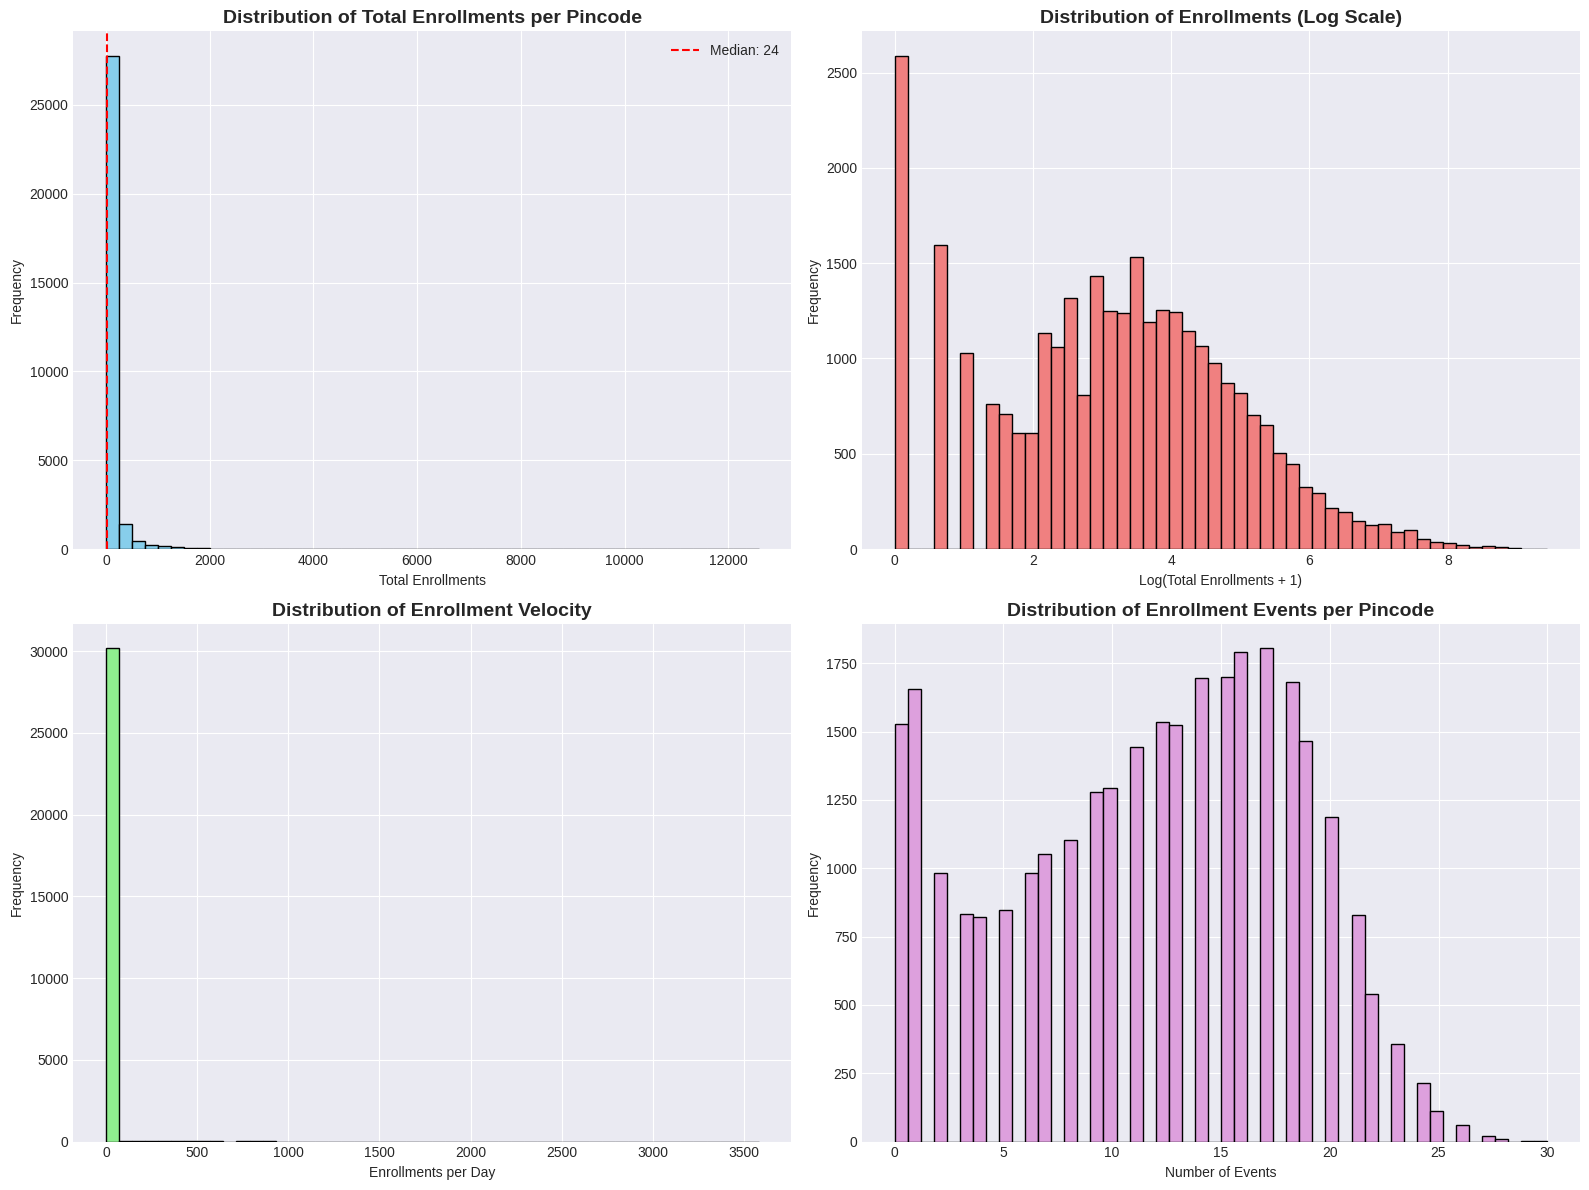

<Figure size 1600x800 with 0 Axes>

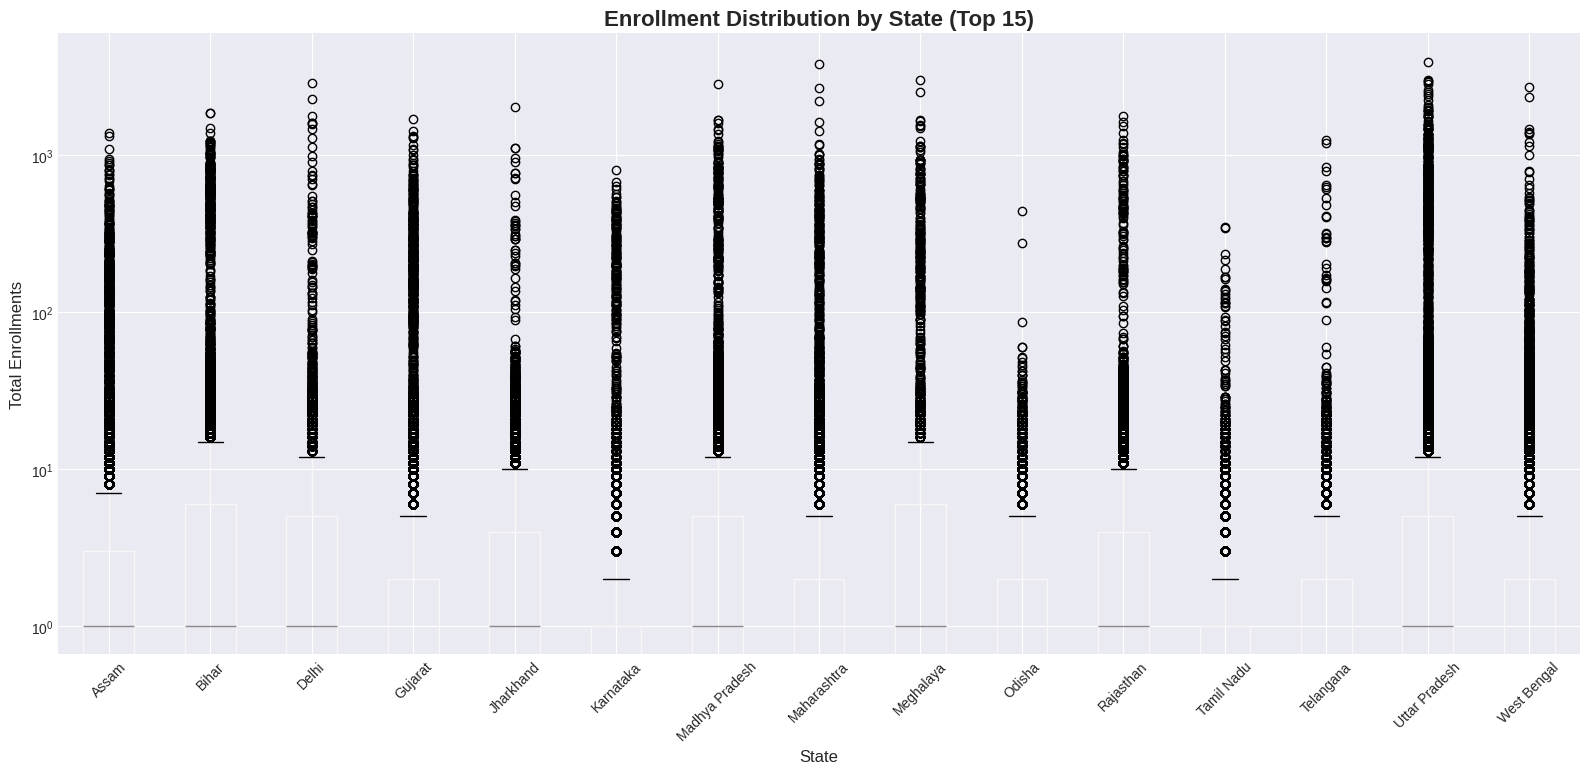

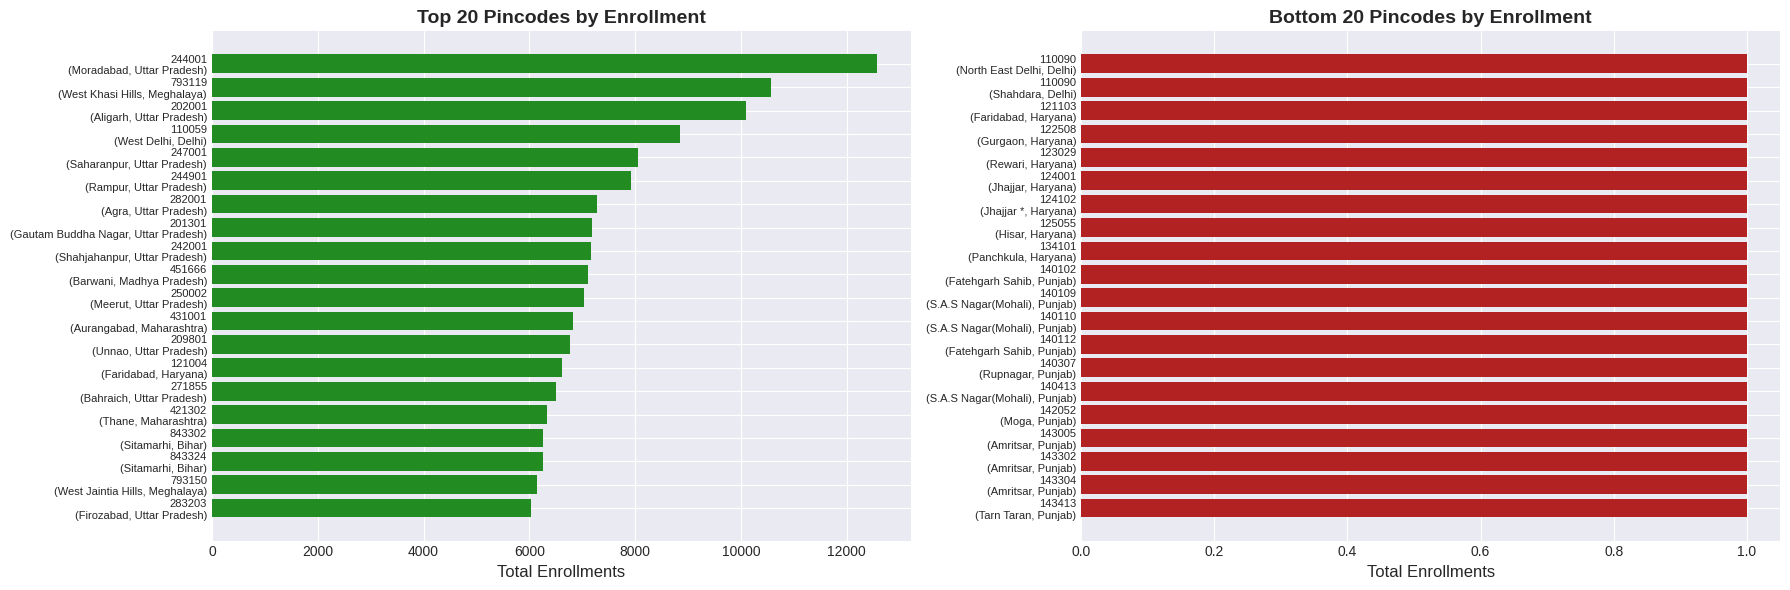

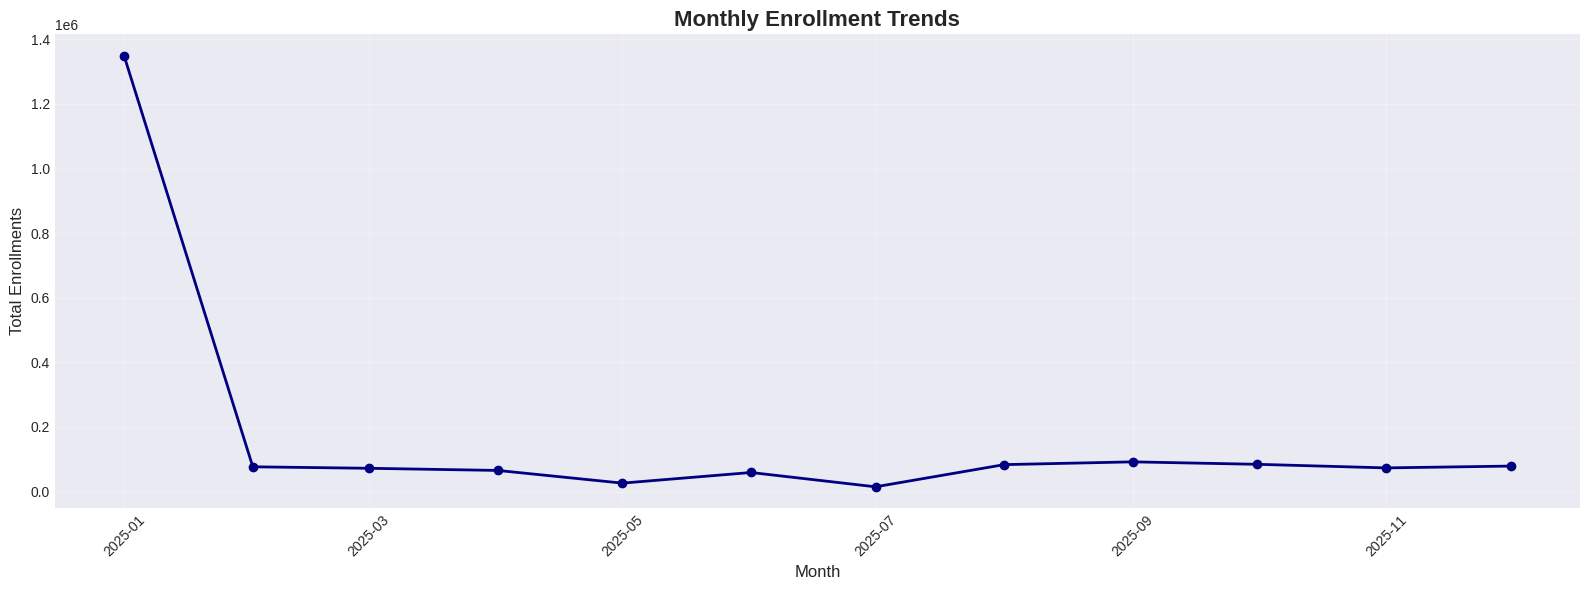


🗺️  2. Geographic Coverage Analysis...

📊 Coverage Metrics:
   Zero enrollment pincodes: 2587
   Low enrollment pincodes (< 10th percentile): 2587
   Total pincodes: 30359


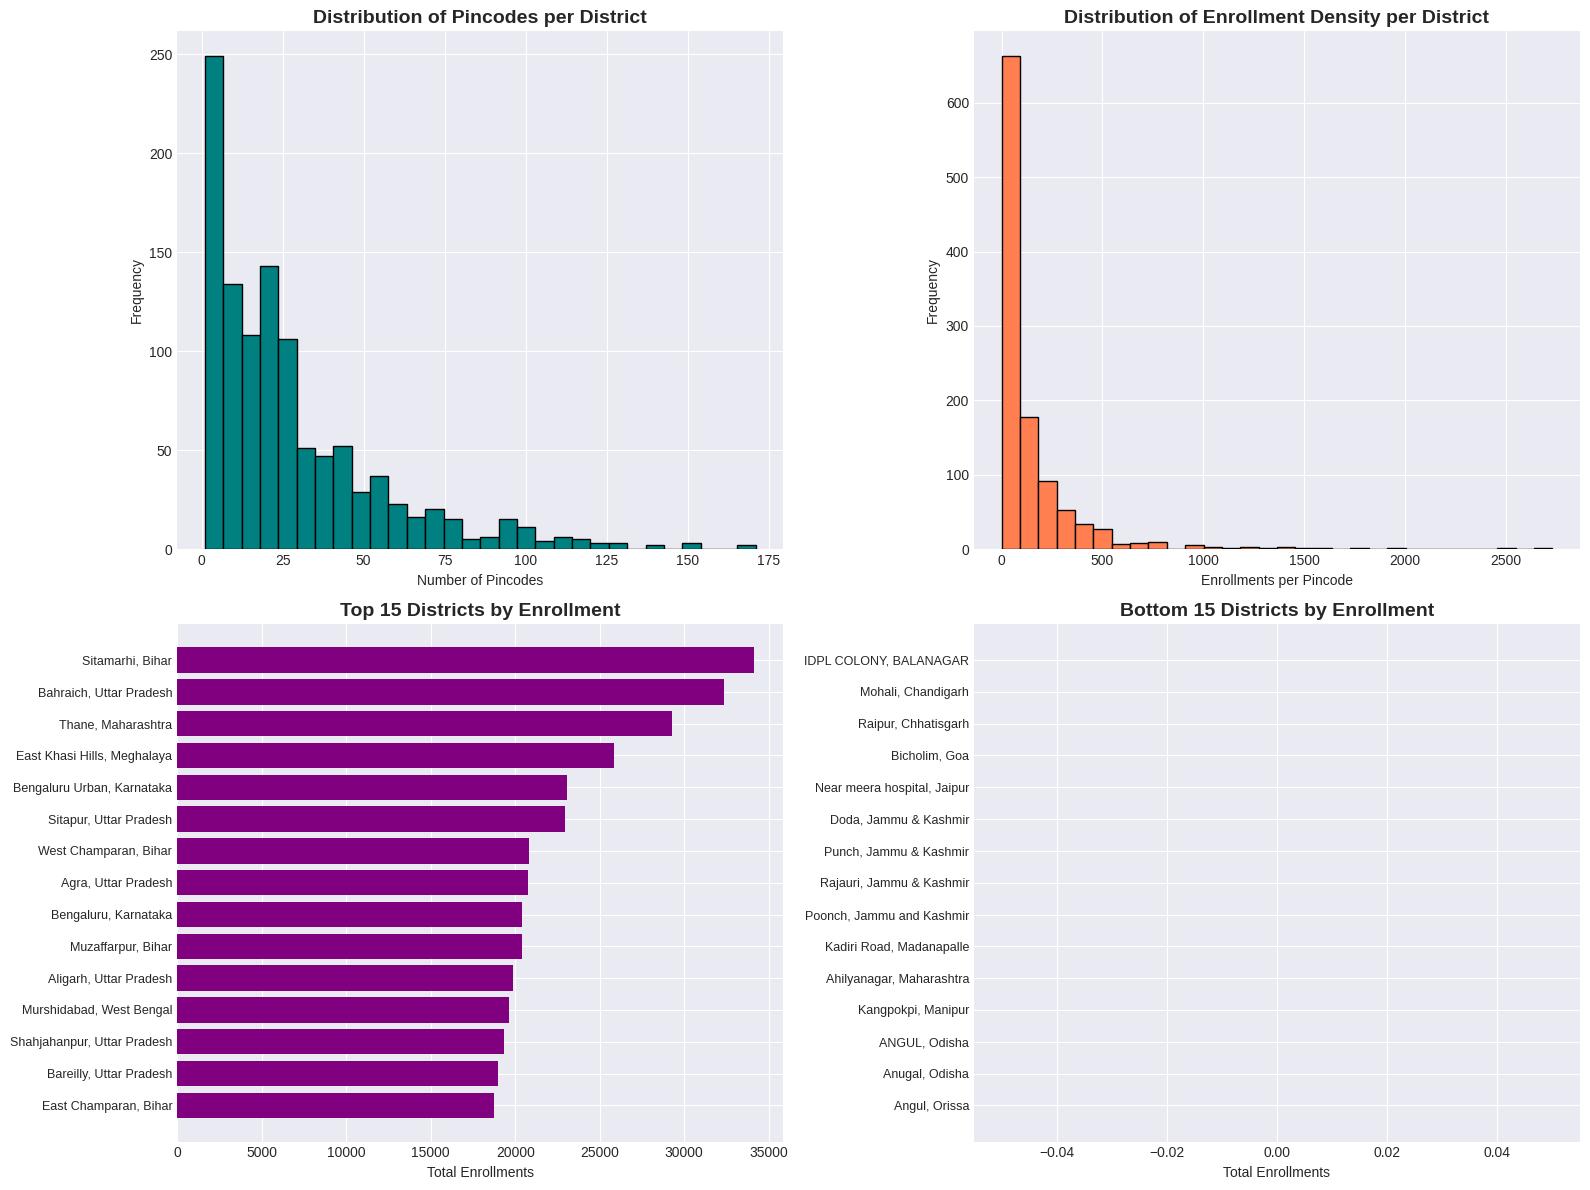


👥 3. Age Group Analysis...


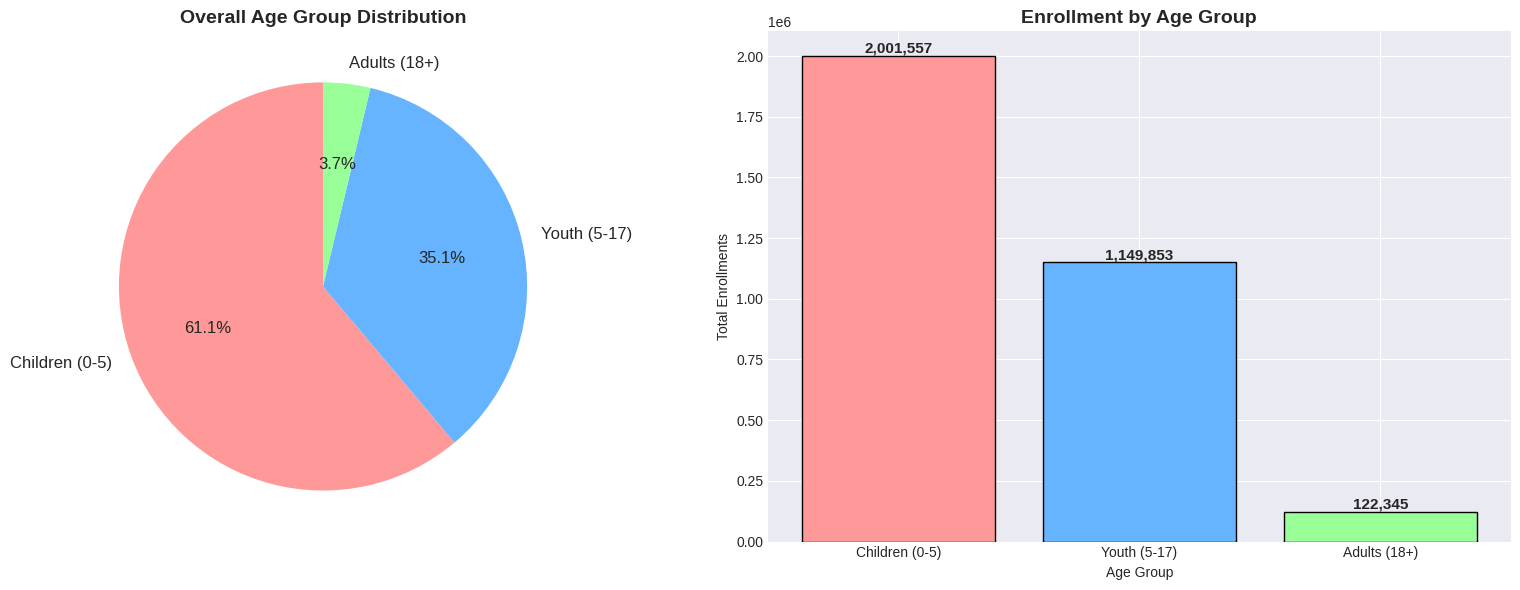

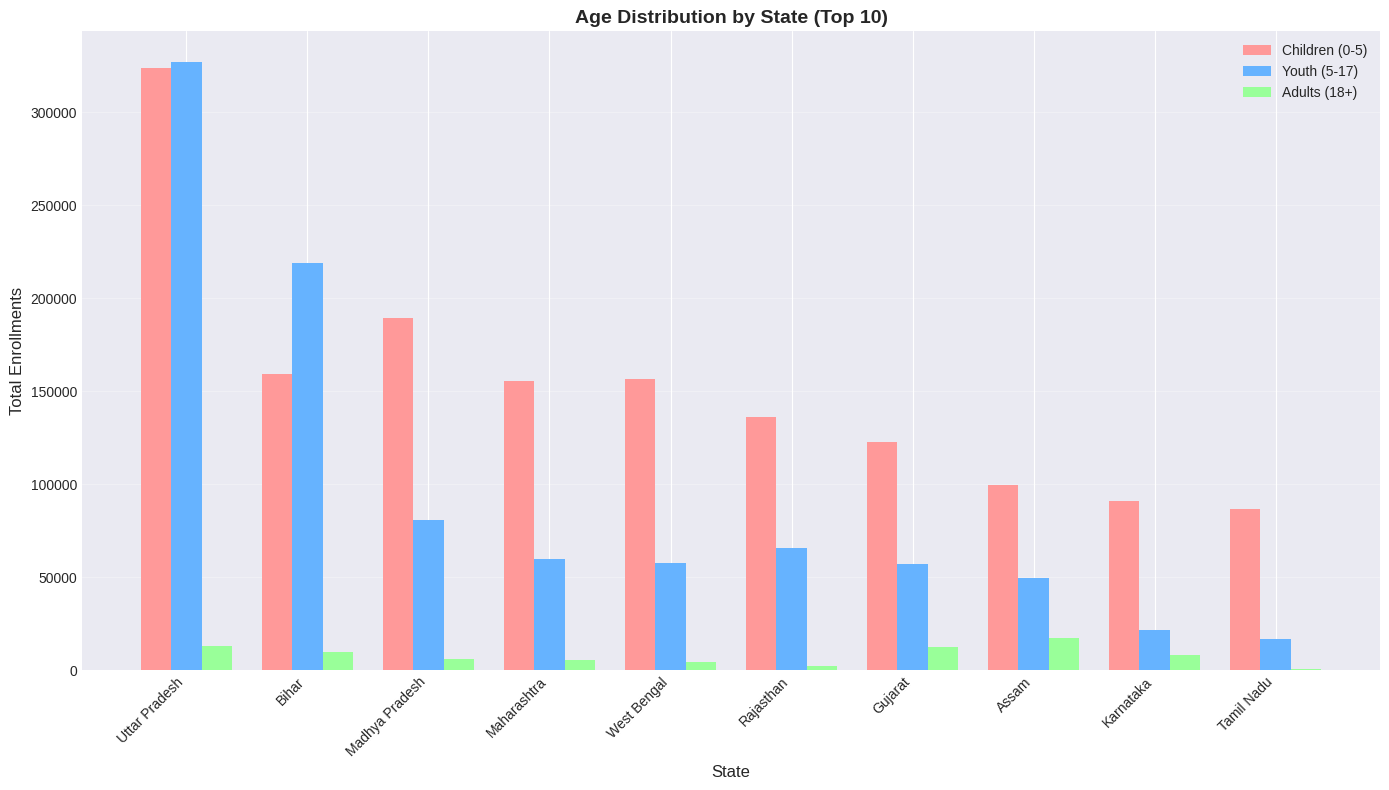

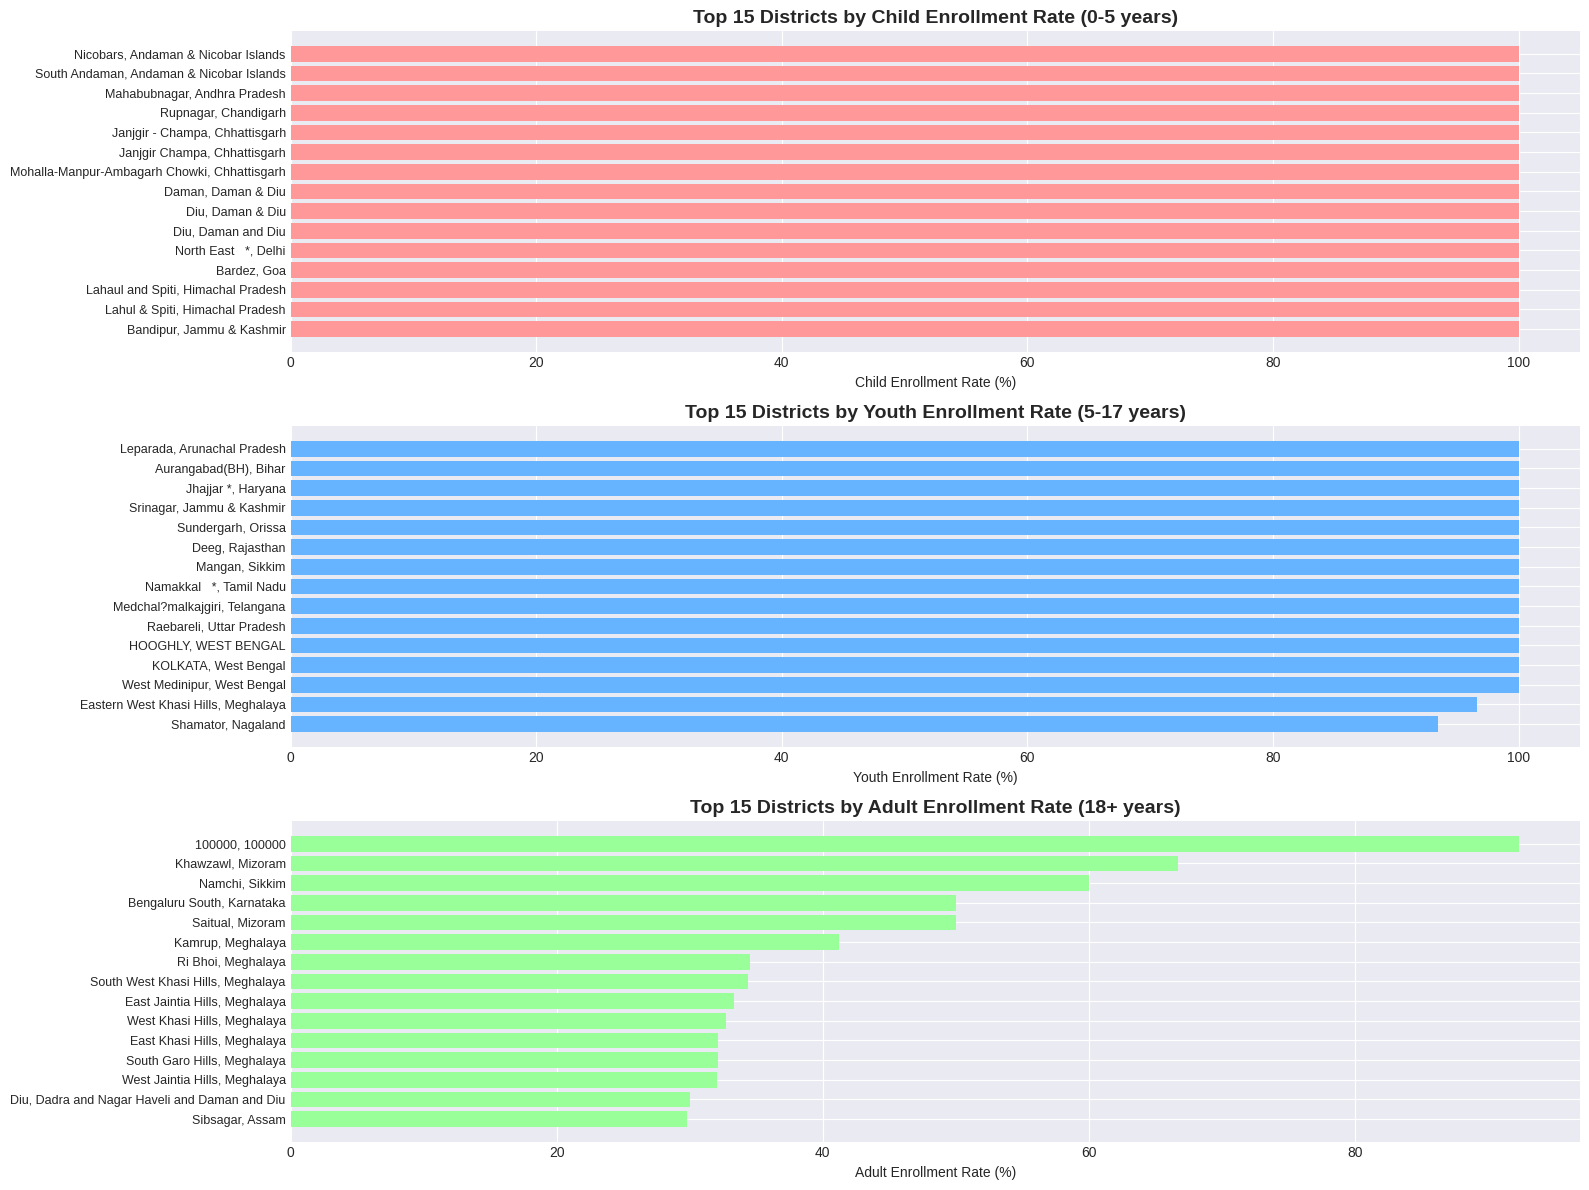


📊 Summary Statistics:

Total Enrollments:3,273,755
Average enrollments per pincode: 107.83
Median enrollments per pincode: 24.00

Age Group Breakdown:
  Children (0-5): 2,001,557 (61.1%)
  Youth (5-17): 1,149,853 (35.1%)
  Adults (18+): 122,345 (3.7%)

✅ PHASE 4 COMPLETE: Univariate Analysis Done!
✅ Generated 8 visualization files in 'figures' folder


In [ ]:
# ========================================
# PHASE 4: Univariate Analysis
# ========================================

print("📊 Starting Univariate Analysis...")
print("=" * 60)

# Create figure directory
import os
os.makedirs('figures', exist_ok=True)

# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ==========================================
# 1. ENROLLMENT DISTRIBUTION ANALYSIS
# ==========================================

print("\n📈 1. Enrollment Distribution Analysis...")

# 1.1 Histogram: Distribution of enrollments per pincode
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total enrollments distribution
axes[0, 0].hist(pincode_agg['total_enrollments'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Total Enrollments per Pincode', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Enrollments')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(pincode_agg['total_enrollments'].median(), color='red', linestyle='--', label=f'Median: {pincode_agg["total_enrollments"].median():.0f}')
axes[0, 0].legend()

# Log scale for better visualization
axes[0, 1].hist(np.log1p(pincode_agg['total_enrollments']), bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Enrollments (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Log(Total Enrollments + 1)')
axes[0, 1].set_ylabel('Frequency')

# Enrollment velocity distribution
axes[1, 0].hist(pincode_agg['enrollment_velocity'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Enrollment Velocity', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Enrollments per Day')
axes[1, 0].set_ylabel('Frequency')

# Enrollment events distribution
axes[1, 1].hist(pincode_agg['enrollment_events'], bins=50, color='plum', edgecolor='black')
axes[1, 1].set_title('Distribution of Enrollment Events per Pincode', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Events')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('figures/01_enrollment_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.2 Box plot: Enrollment distribution by state (top 15 states)
top_states = state_agg.head(15)['state'].tolist()
df_top_states = df_clean[df_clean['state'].isin(top_states)]

plt.figure(figsize=(16, 8))
df_top_states.boxplot(column='total_enrollments', by='state', figsize=(16, 8), rot=45)
plt.title('Enrollment Distribution by State (Top 15)', fontsize=16, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/02_enrollment_boxplot_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.3 Top and Bottom performing pincodes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 20 pincodes
top_20_pincodes = pincode_agg.nlargest(20, 'total_enrollments')
axes[0].barh(range(20), top_20_pincodes['total_enrollments'], color='forestgreen')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels([f"{row['pincode']}\n({row['district']}, {row['state']})"
                          for _, row in top_20_pincodes.iterrows()], fontsize=8)
axes[0].set_xlabel('Total Enrollments', fontsize=12)
axes[0].set_title('Top 20 Pincodes by Enrollment', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Bottom 20 pincodes (excluding zero)
bottom_20_pincodes = pincode_agg[pincode_agg['total_enrollments'] > 0].nsmallest(20, 'total_enrollments')
axes[1].barh(range(20), bottom_20_pincodes['total_enrollments'], color='firebrick')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([f"{row['pincode']}\n({row['district']}, {row['state']})"
                          for _, row in bottom_20_pincodes.iterrows()], fontsize=8)
axes[1].set_xlabel('Total Enrollments', fontsize=12)
axes[1].set_title('Bottom 20 Pincodes by Enrollment', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/03_top_bottom_pincodes.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.4 Time series: Monthly enrollment trends
monthly_trend = df_clean.groupby([df_clean['date'].dt.to_period('M')])['total_enrollments'].sum().reset_index()
monthly_trend['date'] = monthly_trend['date'].dt.to_timestamp()

plt.figure(figsize=(16, 6))
plt.plot(monthly_trend['date'], monthly_trend['total_enrollments'], marker='o', linewidth=2, color='navy')
plt.title('Monthly Enrollment Trends', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/04_monthly_enrollment_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 2. GEOGRAPHIC COVERAGE ANALYSIS
# ==========================================

print("\n🗺️  2. Geographic Coverage Analysis...")

# 2.1 Pincode coverage metrics
zero_enrollment_pincodes = len(pincode_agg[pincode_agg['total_enrollments'] == 0])
low_enrollment_pincodes = len(pincode_agg[pincode_agg['total_enrollments'] < pincode_agg['total_enrollments'].quantile(0.1)])

print(f"\n📊 Coverage Metrics:")
print(f"   Zero enrollment pincodes: {zero_enrollment_pincodes}")
print(f"   Low enrollment pincodes (< 10th percentile): {low_enrollment_pincodes}")
print(f"   Total pincodes: {len(pincode_agg)}")

# 2.2 District coverage visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pincodes per district
axes[0, 0].hist(district_agg['unique_pincodes'], bins=30, color='teal', edgecolor='black')
axes[0, 0].set_title('Distribution of Pincodes per District', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Pincodes')
axes[0, 0].set_ylabel('Frequency')

# Enrollment density per district
axes[0, 1].hist(district_agg['enrollment_density'], bins=30, color='coral', edgecolor='black')
axes[0, 1].set_title('Distribution of Enrollment Density per District', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Enrollments per Pincode')
axes[0, 1].set_ylabel('Frequency')

# Top 15 districts by enrollment
top_15_districts = district_agg.nlargest(15, 'total_enrollments')
axes[1, 0].barh(range(15), top_15_districts['total_enrollments'], color='purple')
axes[1, 0].set_yticks(range(15))
axes[1, 0].set_yticklabels([f"{row['district']}, {row['state']}"
                             for _, row in top_15_districts.iterrows()], fontsize=9)
axes[1, 0].set_xlabel('Total Enrollments')
axes[1, 0].set_title('Top 15 Districts by Enrollment', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# Bottom 15 districts by enrollment
bottom_15_districts = district_agg.nsmallest(15, 'total_enrollments')
axes[1, 1].barh(range(15), bottom_15_districts['total_enrollments'], color='orangered')
axes[1, 1].set_yticks(range(15))
axes[1, 1].set_yticklabels([f"{row['district']}, {row['state']}"
                             for _, row in bottom_15_districts.iterrows()], fontsize=9)
axes[1, 1].set_xlabel('Total Enrollments')
axes[1, 1].set_title('Bottom 15 Districts by Enrollment', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/05_geographic_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. AGE GROUP ANALYSIS
# ==========================================

print("\n👥 3. Age Group Analysis...")

# 3.1 Overall age distribution (pie chart)
age_totals = {
    'Children (0-5)': df_clean['age_0_5'].sum(),
    'Youth (5-17)': df_clean['age_5_17'].sum(),
    'Adults (18+)': df_clean['age_18_greater'].sum()
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[0].pie(age_totals.values(), labels=age_totals.keys(), autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[0].set_title('Overall Age Group Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(age_totals.keys(), age_totals.values(), color=colors, edgecolor='black')
axes[1].set_title('Enrollment by Age Group', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Enrollments')
axes[1].set_xlabel('Age Group')
for i, (k, v) in enumerate(age_totals.items()):
    axes[1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/06_age_group_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 Age distribution by state (top 10 states)
top_10_states = state_agg.head(10)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_10_states))
width = 0.25

bars1 = ax.bar(x - width, top_10_states['total_age_0_5'], width, label='Children (0-5)', color='#ff9999')
bars2 = ax.bar(x, top_10_states['total_age_5_17'], width, label='Youth (5-17)', color='#66b3ff')
bars3 = ax.bar(x + width, top_10_states['total_age_18_greater'], width, label='Adults (18+)', color='#99ff99')

ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Total Enrollments', fontsize=12)
ax.set_title('Age Distribution by State (Top 10)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_states['state'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/07_age_distribution_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.3 Age rate comparison across districts
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Child enrollment rate
top_child = district_agg.nlargest(15, 'child_rate')
axes[0].barh(range(15), top_child['child_rate'], color='#ff9999')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels([f"{row['district']}, {row['state']}" for _, row in top_child.iterrows()], fontsize=9)
axes[0].set_xlabel('Child Enrollment Rate (%)')
axes[0].set_title('Top 15 Districts by Child Enrollment Rate (0-5 years)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Youth enrollment rate
top_youth = district_agg.nlargest(15, 'youth_rate')
axes[1].barh(range(15), top_youth['youth_rate'], color='#66b3ff')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels([f"{row['district']}, {row['state']}" for _, row in top_youth.iterrows()], fontsize=9)
axes[1].set_xlabel('Youth Enrollment Rate (%)')
axes[1].set_title('Top 15 Districts by Youth Enrollment Rate (5-17 years)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# Adult enrollment rate
top_adult = district_agg.nlargest(15, 'adult_rate')
axes[2].barh(range(15), top_adult['adult_rate'], color='#99ff99')
axes[2].set_yticks(range(15))
axes[2].set_yticklabels([f"{row['district']}, {row['state']}" for _, row in top_adult.iterrows()], fontsize=9)
axes[2].set_xlabel('Adult Enrollment Rate (%)')
axes[2].set_title('Top 15 Districts by Adult Enrollment Rate (18+ years)', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/08_age_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n📊 Summary Statistics:")
print(f"\nTotal Enrollments:{df_clean['total_enrollments'].sum():,.0f}")
print(f"Average enrollments per pincode: {pincode_agg['total_enrollments'].mean():,.2f}")
print(f"Median enrollments per pincode: {pincode_agg['total_enrollments'].median():,.2f}")
print(f"\nAge Group Breakdown:")
print(f"  Children (0-5): {age_totals['Children (0-5)']:,.0f} ({age_totals['Children (0-5)']/sum(age_totals.values())*100:.1f}%)")
print(f"  Youth (5-17): {age_totals['Youth (5-17)']:,.0f} ({age_totals['Youth (5-17)']/sum(age_totals.values())*100:.1f}%)")
print(f"  Adults (18+): {age_totals['Adults (18+)']:,.0f} ({age_totals['Adults (18+)']/sum(age_totals.values())*100:.1f}%)")
print("\n" + "=" * 60)
print("✅ PHASE 4 COMPLETE: Univariate Analysis Done!")
print(f"✅ Generated 8 visualization files in 'figures' folder")
print("=" * 60)

📊 Starting Bivariate Analysis...

🗺️  1. Geography vs Enrollment Analysis...


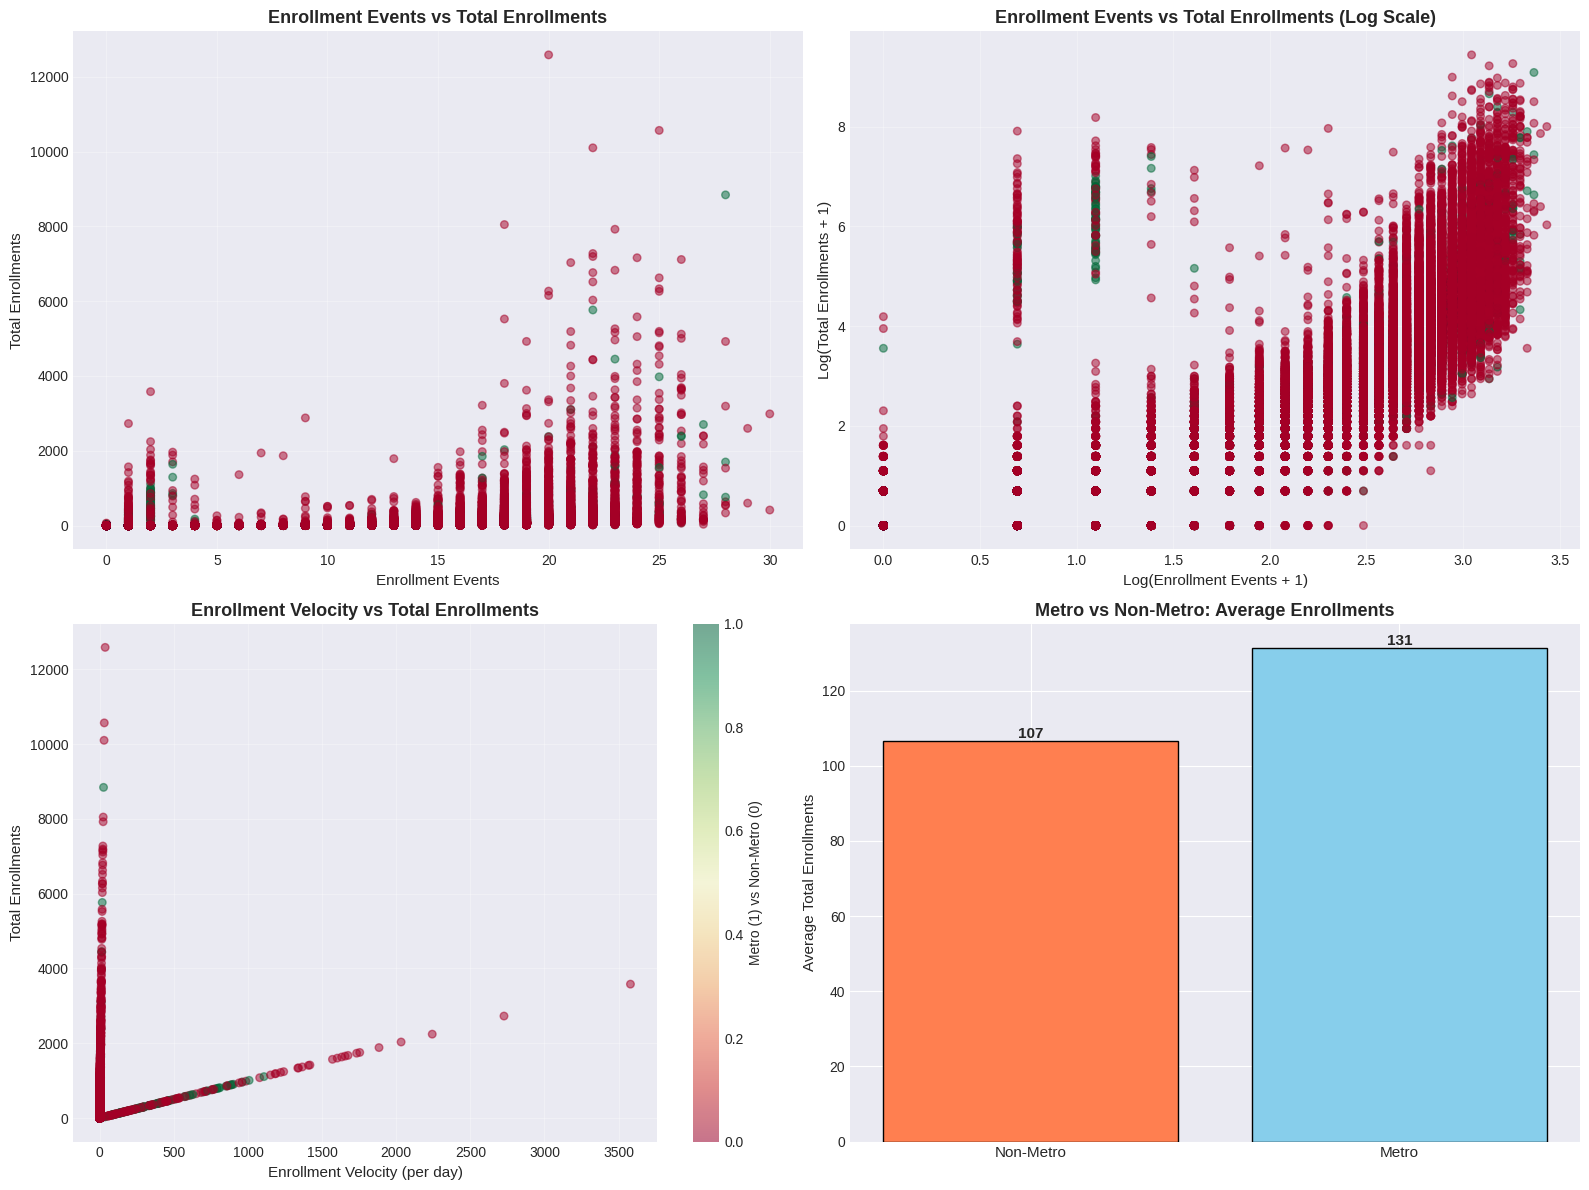


📊 Creating State × District Enrollment Heatmap...


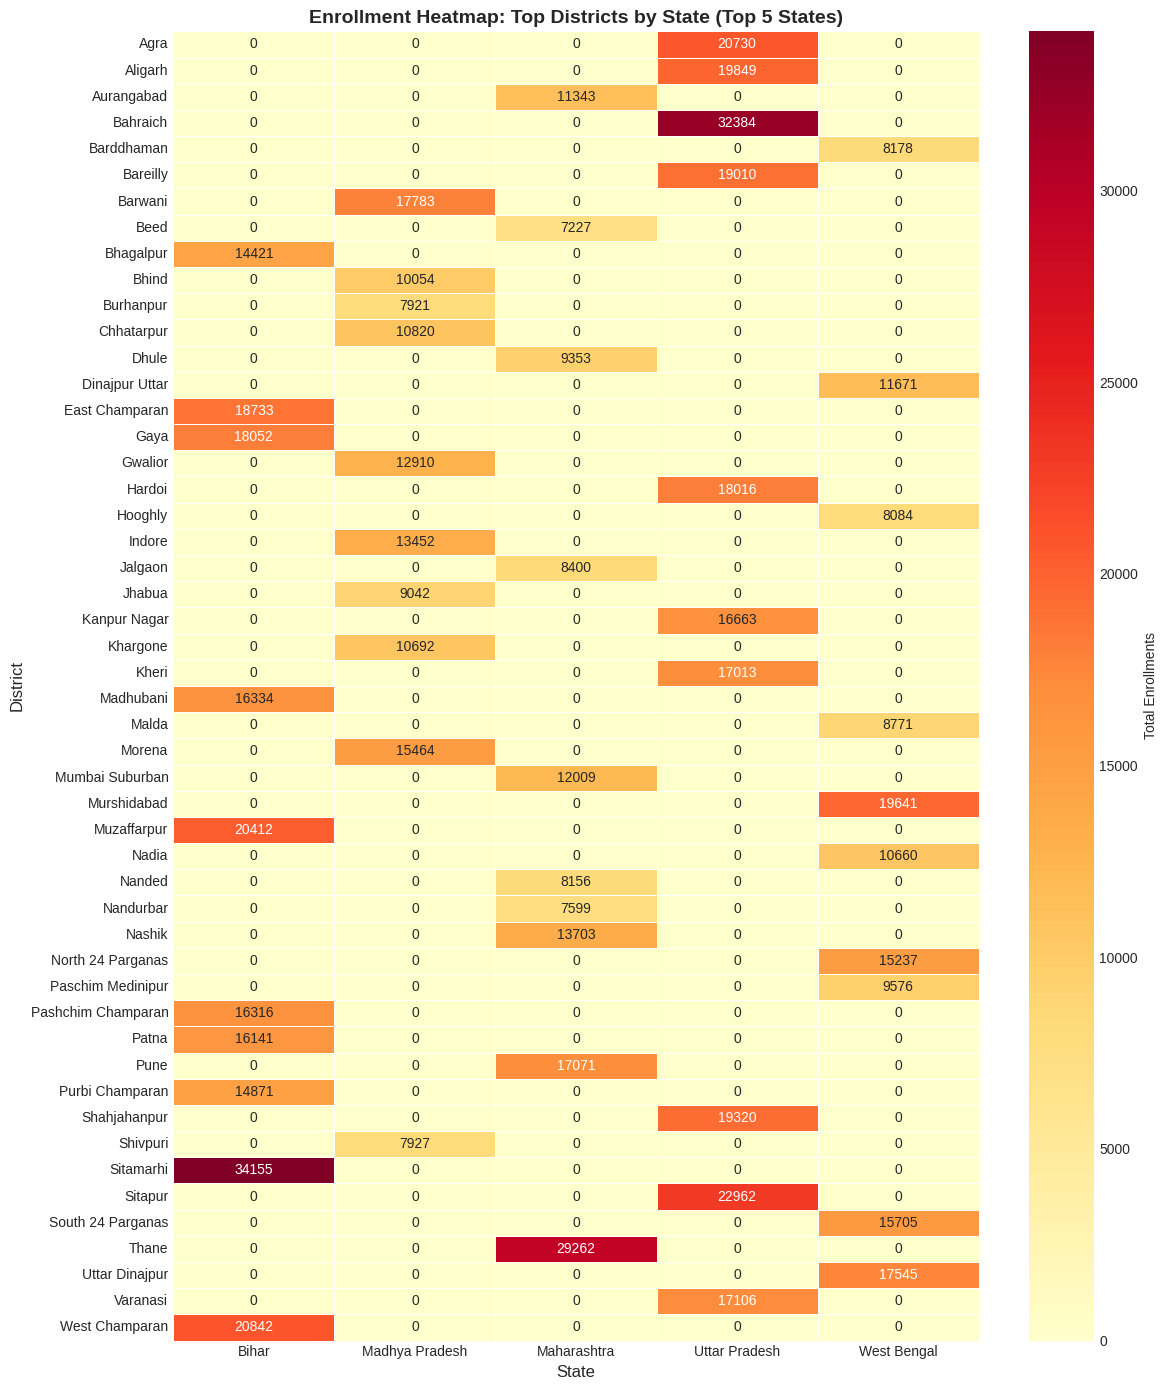


⏰ 2. Time vs Enrollment Analysis...


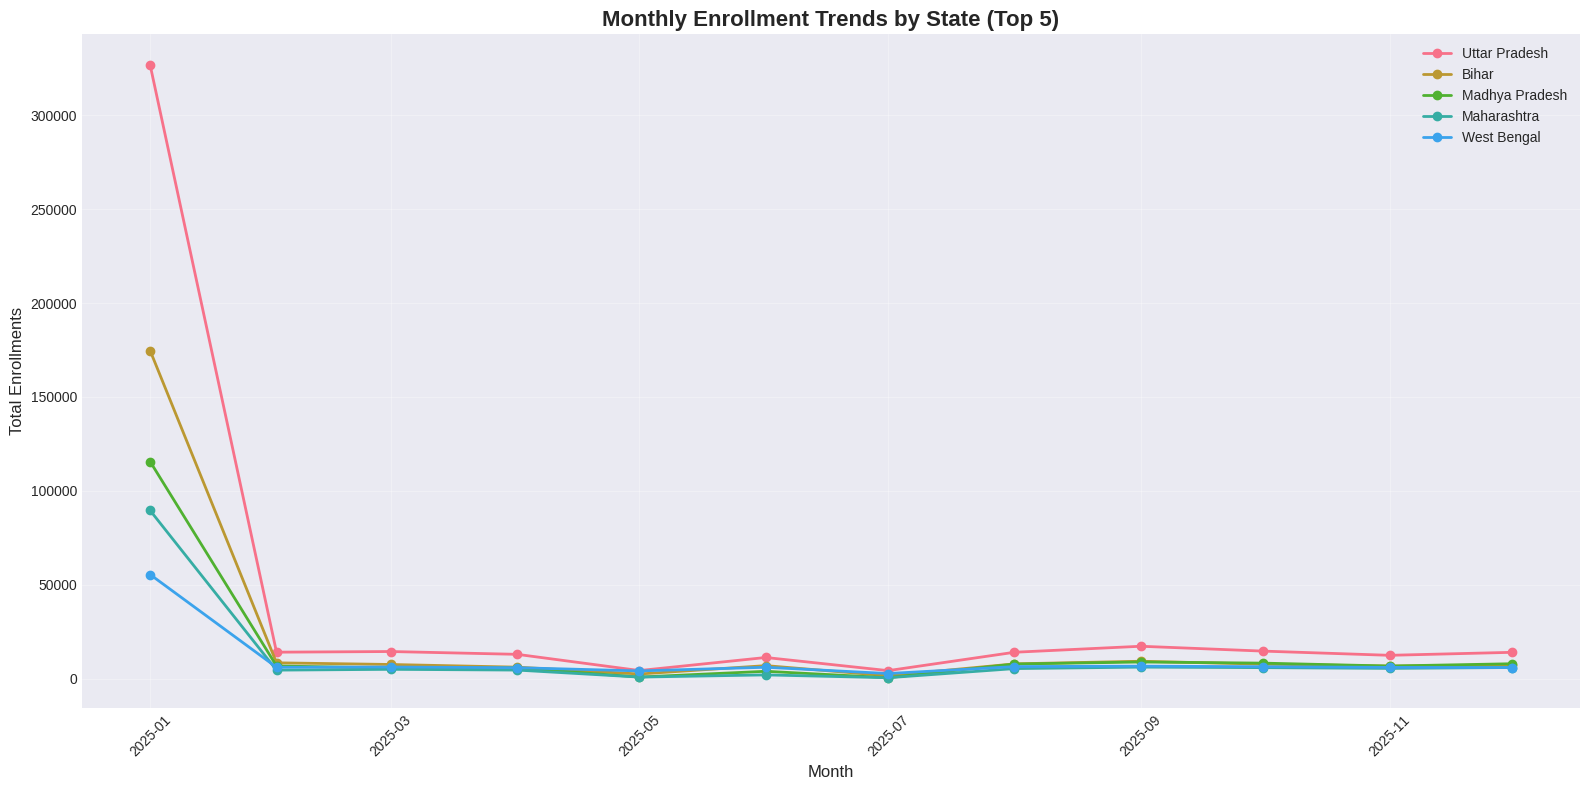

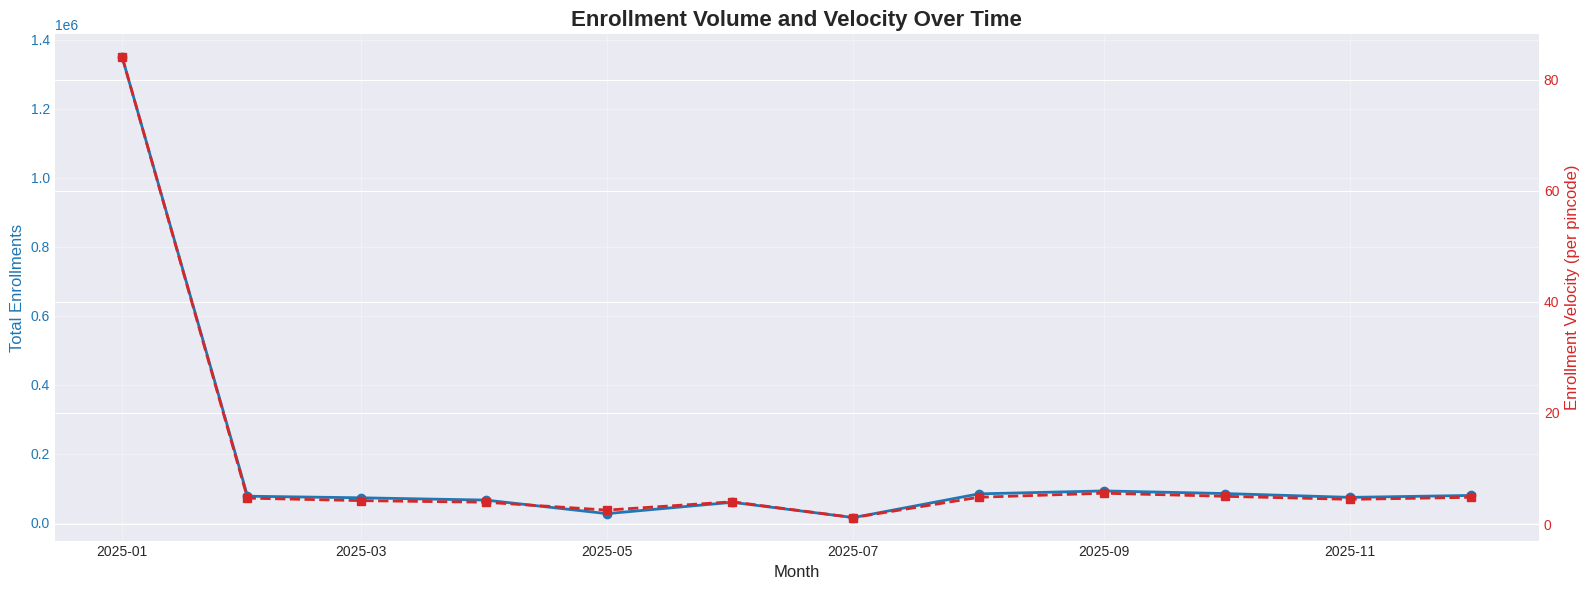

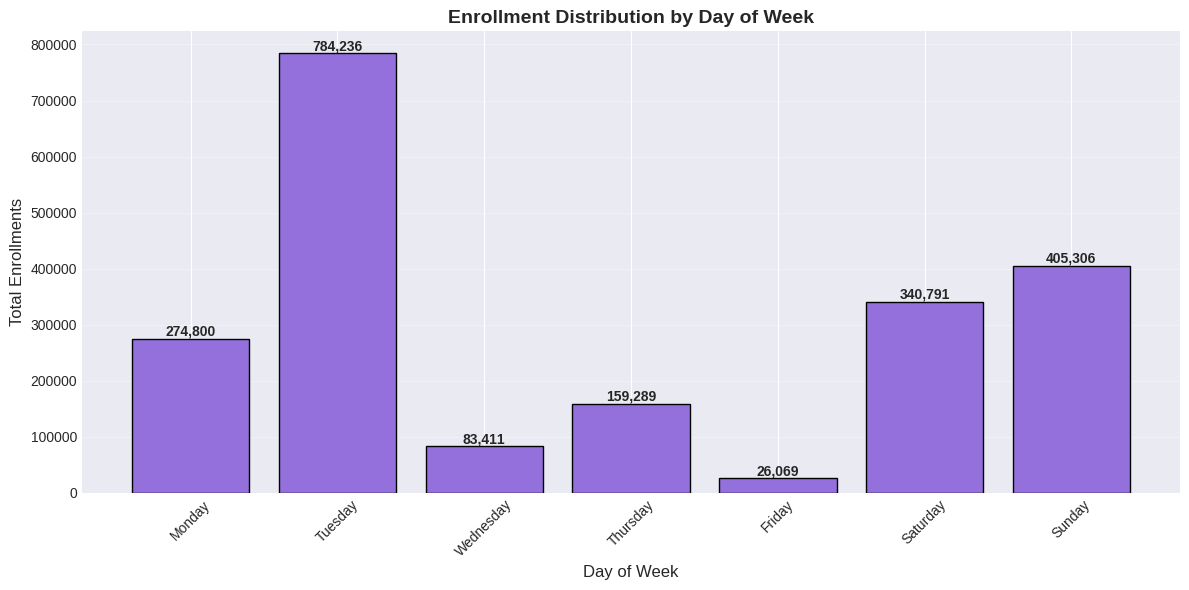


👥 3. Demographics vs Geography Analysis...


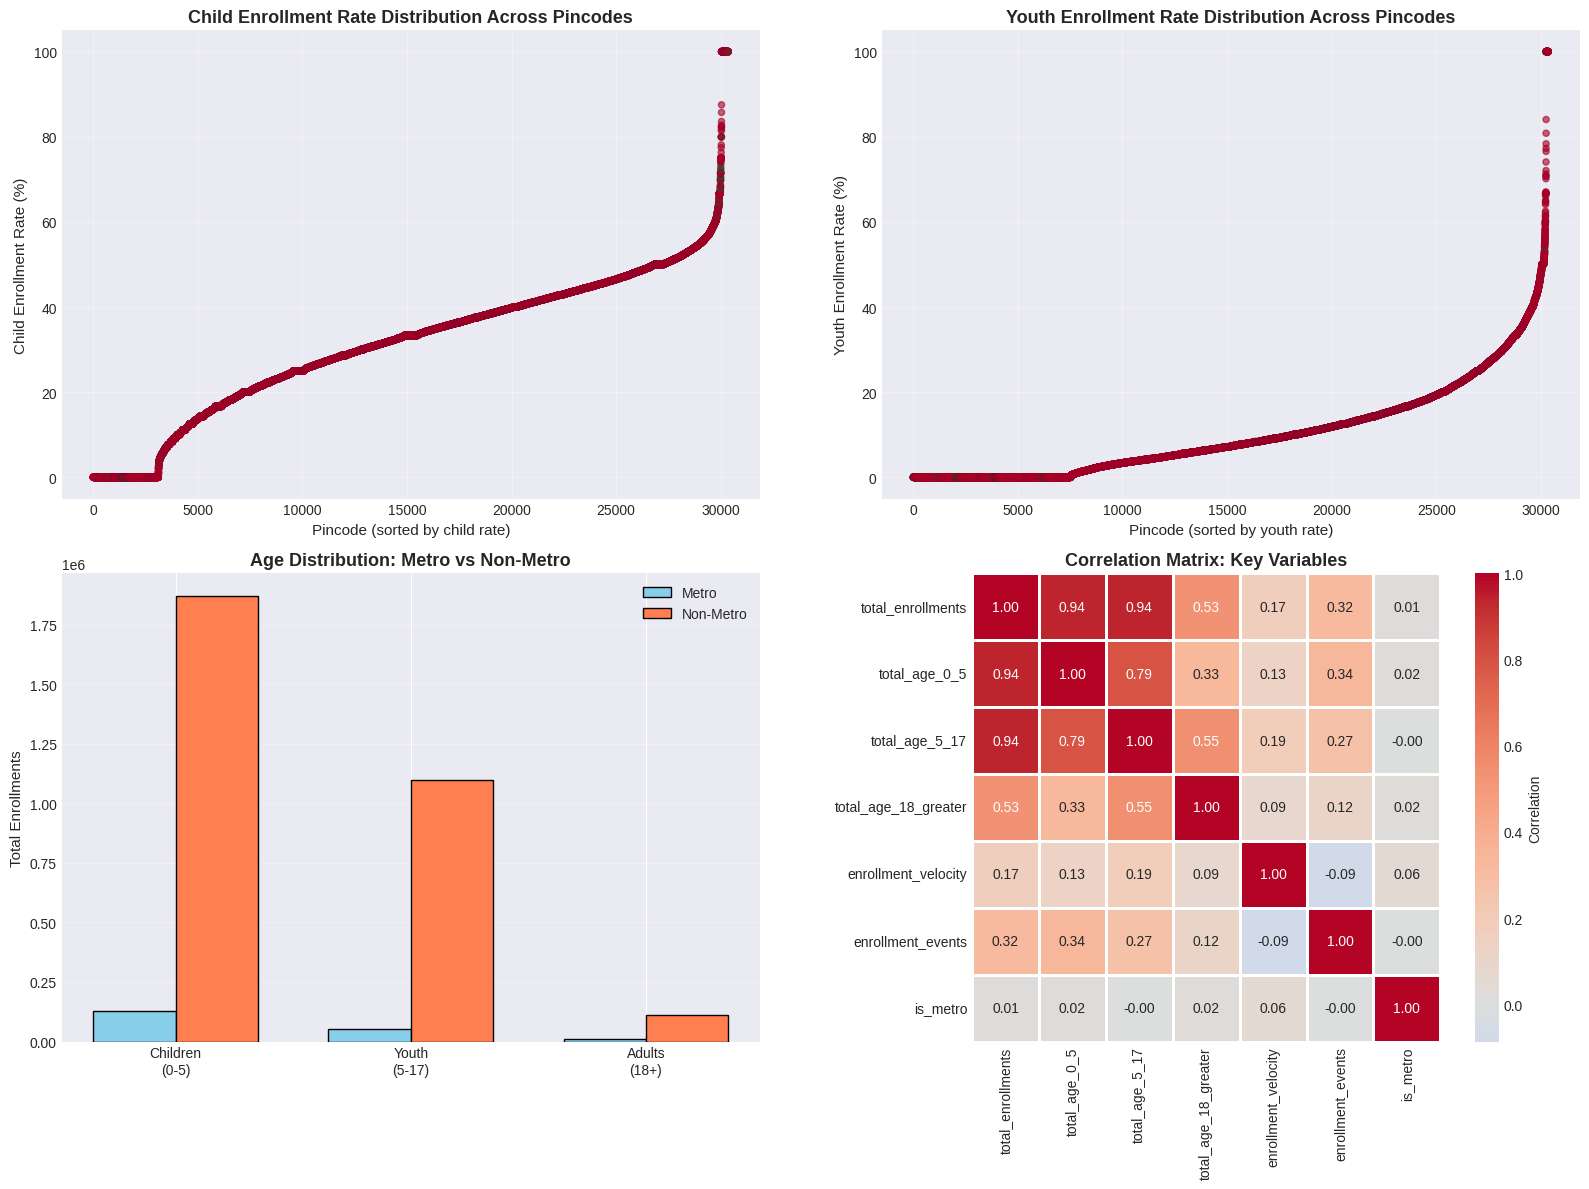

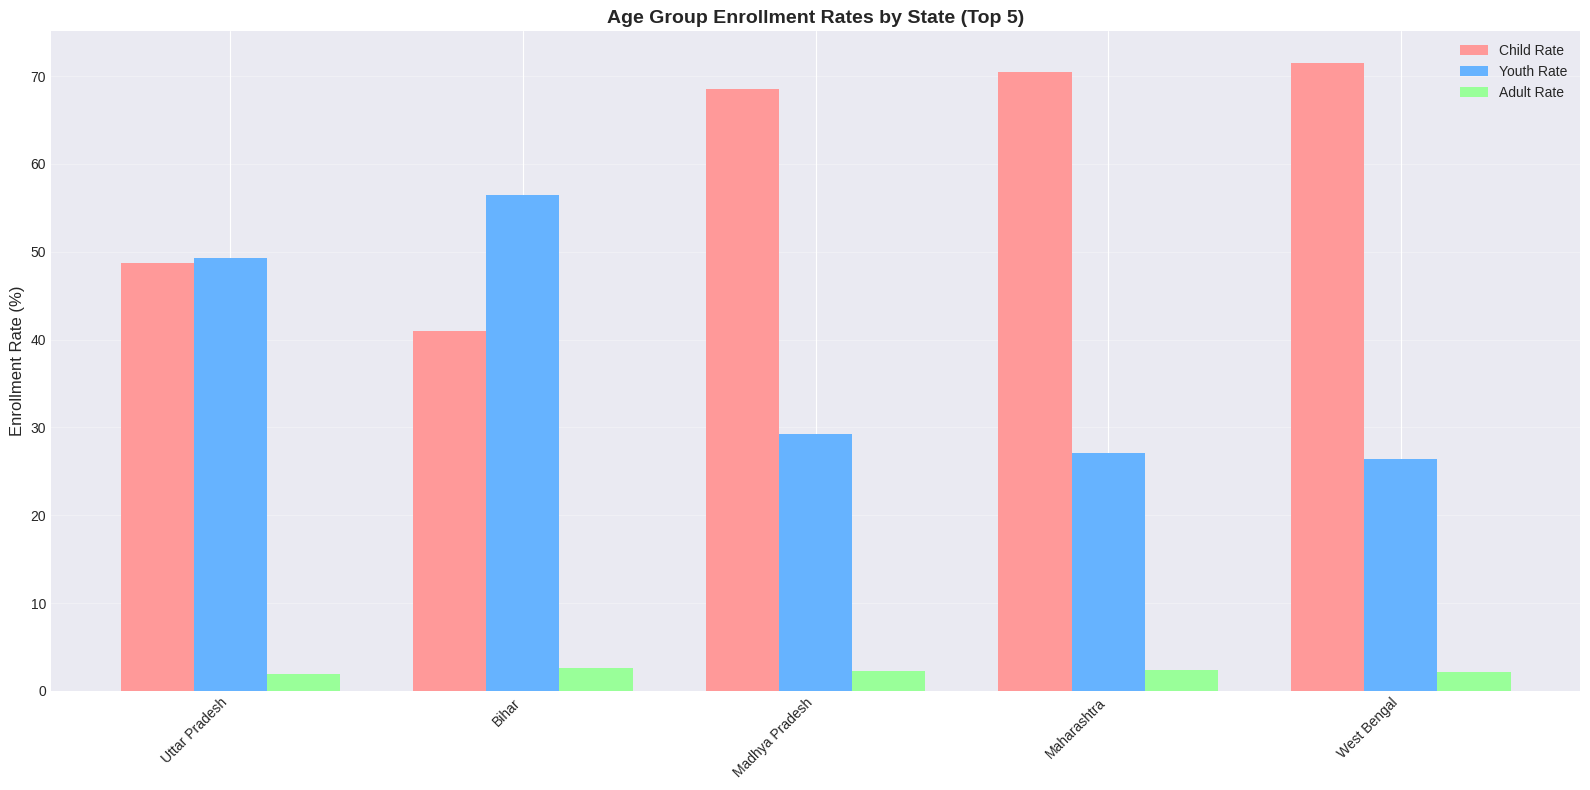


📊 Bivariate Analysis Key Insights:
   Metro pincodes average: 131 enrollments
   Non-metro pincodes average: 107 enrollments
   Correlation (events vs enrollments): 0.321
   Correlation (velocity vs enrollments): 0.166

✅ PHASE 5 COMPLETE: Bivariate Analysis Done!
✅ Generated 7 additional visualization files


In [ ]:


## **PHASE 5: Bivariate Analysis**

# ========================================
# PHASE 5: Bivariate Analysis
# ========================================

print("📊 Starting Bivariate Analysis...")
print("=" * 60)

# ==========================================
# 1. GEOGRAPHY VS ENROLLMENT
# ==========================================

print("\n🗺️  1. Geography vs Enrollment Analysis...")

# 1.1 Scatter plot: Enrollment events vs total enrollments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Enrollment events vs total enrollments
axes[0, 0].scatter(pincode_agg['enrollment_events'], pincode_agg['total_enrollments'],
                   alpha=0.5, c=pincode_agg['is_metro'], cmap='RdYlGn', s=30)
axes[0, 0].set_xlabel('Enrollment Events', fontsize=11)
axes[0, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[0, 0].set_title('Enrollment Events vs Total Enrollments', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Log-log scale for better visualization
axes[0, 1].scatter(np.log1p(pincode_agg['enrollment_events']),
                   np.log1p(pincode_agg['total_enrollments']),
                   alpha=0.5, c=pincode_agg['is_metro'], cmap='RdYlGn', s=30)
axes[0, 1].set_xlabel('Log(Enrollment Events + 1)', fontsize=11)
axes[0, 1].set_ylabel('Log(Total Enrollments + 1)', fontsize=11)
axes[0, 1].set_title('Enrollment Events vs Total Enrollments (Log Scale)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Enrollment velocity vs total enrollments
scatter = axes[1, 0].scatter(pincode_agg['enrollment_velocity'],
                             pincode_agg['total_enrollments'],
                             alpha=0.5, c=pincode_agg['is_metro'], cmap='RdYlGn', s=30)
axes[1, 0].set_xlabel('Enrollment Velocity (per day)', fontsize=11)
axes[1, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[1, 0].set_title('Enrollment Velocity vs Total Enrollments', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Metro (1) vs Non-Metro (0)')

# Urban vs Rural comparison
urban_rural_data = pincode_agg.groupby('is_metro')[['total_enrollments', 'enrollment_velocity']].mean()
x_pos = np.arange(len(urban_rural_data))
axes[1, 1].bar(x_pos, urban_rural_data['total_enrollments'], color=['coral', 'skyblue'], edgecolor='black')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(['Non-Metro', 'Metro'], fontsize=11)
axes[1, 1].set_ylabel('Average Total Enrollments', fontsize=11)
axes[1, 1].set_title('Metro vs Non-Metro: Average Enrollments', fontsize=13, fontweight='bold')
for i, v in enumerate(urban_rural_data['total_enrollments']):
    axes[1, 1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/09_geography_vs_enrollment.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.2 State × District heatmap (top 5 states, top districts)
print("\n📊 Creating State × District Enrollment Heatmap...")

# Select top 5 states
top_5_states = state_agg.head(5)['state'].tolist()
district_subset = district_agg[district_agg['state'].isin(top_5_states)]

# Get top 10 districts per state
top_districts_per_state = []
for state in top_5_states:
    state_districts = district_subset[district_subset['state'] == state].nlargest(10, 'total_enrollments')
    top_districts_per_state.append(state_districts)

district_pivot = pd.concat(top_districts_per_state)

# Create pivot table
pivot_data = district_pivot.pivot_table(
    values='total_enrollments',
    index='district',
    columns='state',
    fill_value=0
)

plt.figure(figsize=(12, 14))
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Total Enrollments'}, linewidths=0.5)
plt.title('Enrollment Heatmap: Top Districts by State (Top 5 States)', fontsize=14, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.savefig('figures/10_state_district_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 2. TIME VS ENROLLMENT
# ==========================================

print("\n⏰ 2. Time vs Enrollment Analysis...")

# 2.1 Monthly enrollment trends by state (top 5)
monthly_state_trend = df_clean[df_clean['state'].isin(top_5_states)].groupby(
    [df_clean['date'].dt.to_period('M'), 'state']
)['total_enrollments'].sum().reset_index()
monthly_state_trend['date'] = monthly_state_trend['date'].dt.to_timestamp()

plt.figure(figsize=(16, 8))
for state in top_5_states:
    state_data = monthly_state_trend[monthly_state_trend['state'] == state]
    plt.plot(state_data['date'], state_data['total_enrollments'],
             marker='o', linewidth=2, label=state)

plt.title('Monthly Enrollment Trends by State (Top 5)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/11_monthly_trends_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.2 Enrollment velocity over time
# Create monthly aggregation with velocity
monthly_velocity = df_clean.groupby(df_clean['date'].dt.to_period('M')).agg({
    'total_enrollments': 'sum',
    'pincode': 'nunique'
}).reset_index()
monthly_velocity['date'] = monthly_velocity['date'].dt.to_timestamp()
monthly_velocity['velocity'] = monthly_velocity['total_enrollments'] / monthly_velocity['pincode']

fig, ax1 = plt.subplots(figsize=(16, 6))

color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Enrollments', color=color, fontsize=12)
ax1.plot(monthly_velocity['date'], monthly_velocity['total_enrollments'],
         color=color, marker='o', linewidth=2, label='Total Enrollments')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Enrollment Velocity (per pincode)', color=color, fontsize=12)
ax2.plot(monthly_velocity['date'], monthly_velocity['velocity'],
         color=color, marker='s', linewidth=2, label='Velocity', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Enrollment Volume and Velocity Over Time', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig('figures/12_enrollment_velocity_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.3 Day of week analysis
day_of_week_enrollment = df_clean.groupby('enrollment_day_of_week')['total_enrollments'].sum()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
plt.bar(range(7), day_of_week_enrollment, color='mediumpurple', edgecolor='black')
plt.xticks(range(7), days, rotation=45)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.title('Enrollment Distribution by Day of Week', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(day_of_week_enrollment):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/13_day_of_week_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. DEMOGRAPHICS VS GEOGRAPHY
# ==========================================

print("\n👥 3. Demographics vs Geography Analysis...")

# 3.1 Child enrollment rate vs pincode
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Child enrollment rate distribution
axes[0, 0].scatter(range(len(pincode_agg)),
                   pincode_agg.sort_values('avg_child_rate')['avg_child_rate'],
                   c=pincode_agg.sort_values('avg_child_rate')['is_metro'],
                   cmap='RdYlGn', alpha=0.6, s=20)
axes[0, 0].set_xlabel('Pincode (sorted by child rate)', fontsize=11)
axes[0, 0].set_ylabel('Child Enrollment Rate (%)', fontsize=11)
axes[0, 0].set_title('Child Enrollment Rate Distribution Across Pincodes', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Youth enrollment rate distribution
axes[0, 1].scatter(range(len(pincode_agg)),
                   pincode_agg.sort_values('avg_youth_rate')['avg_youth_rate'],
                   c=pincode_agg.sort_values('avg_youth_rate')['is_metro'],
                   cmap='RdYlGn', alpha=0.6, s=20)
axes[0, 1].set_xlabel('Pincode (sorted by youth rate)', fontsize=11)
axes[0, 1].set_ylabel('Youth Enrollment Rate (%)', fontsize=11)
axes[0, 1].set_title('Youth Enrollment Rate Distribution Across Pincodes', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Metro vs Non-Metro age distribution
metro_age = pincode_agg[pincode_agg['is_metro'] == 1][['total_age_0_5', 'total_age_5_17', 'total_age_18_greater']].sum()
non_metro_age = pincode_agg[pincode_agg['is_metro'] == 0][['total_age_0_5', 'total_age_5_17', 'total_age_18_greater']].sum()

x = np.arange(3)
width = 0.35
age_groups = ['Children\n(0-5)', 'Youth\n(5-17)', 'Adults\n(18+)']

axes[1, 0].bar(x - width/2, metro_age, width, label='Metro', color='skyblue', edgecolor='black')
axes[1, 0].bar(x + width/2, non_metro_age, width, label='Non-Metro', color='coral', edgecolor='black')
axes[1, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[1, 0].set_title('Age Distribution: Metro vs Non-Metro', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(age_groups)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Correlation heatmap
correlation_data = pincode_agg[[
    'total_enrollments', 'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'enrollment_velocity', 'enrollment_events', 'is_metro'
]].corr()

sns.heatmap(correlation_data, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, ax=axes[1, 1],
            cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Correlation Matrix: Key Variables', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/14_demographics_vs_geography.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 State-wise age group rates comparison
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(top_5_states))
width = 0.25

state_subset = state_agg[state_agg['state'].isin(top_5_states)]

bars1 = ax.bar(x - width, state_subset['child_rate'], width, label='Child Rate', color='#ff9999')
bars2 = ax.bar(x, state_subset['youth_rate'], width, label='Youth Rate', color='#66b3ff')
bars3 = ax.bar(x + width, state_subset['adult_rate'], width, label='Adult Rate', color='#99ff99')

ax.set_ylabel('Enrollment Rate (%)', fontsize=12)
ax.set_title('Age Group Enrollment Rates by State (Top 5)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(state_subset['state'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/15_age_rates_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Bivariate Analysis Key Insights:")
print(f"   Metro pincodes average: {pincode_agg[pincode_agg['is_metro']==1]['total_enrollments'].mean():.0f} enrollments")
print(f"   Non-metro pincodes average: {pincode_agg[pincode_agg['is_metro']==0]['total_enrollments'].mean():.0f} enrollments")
print(f"   Correlation (events vs enrollments): {pincode_agg['enrollment_events'].corr(pincode_agg['total_enrollments']):.3f}")
print(f"   Correlation (velocity vs enrollments): {pincode_agg['enrollment_velocity'].corr(pincode_agg['total_enrollments']):.3f}")

print("\n" + "=" * 60)
print("✅ PHASE 5 COMPLETE: Bivariate Analysis Done!")
print(f"✅ Generated 7 additional visualization files")
print("=" * 60)

📊 Starting Trivariate Analysis...

🌐 1. Creating Interactive Visualizations...
✅ Created: 16_3d_scatter_plot.html
✅ Created: 17_animated_bubble_chart.html
✅ Created: 18_sunburst_hierarchy.html

🔥 2. Creating Multi-Dimensional Heatmaps...


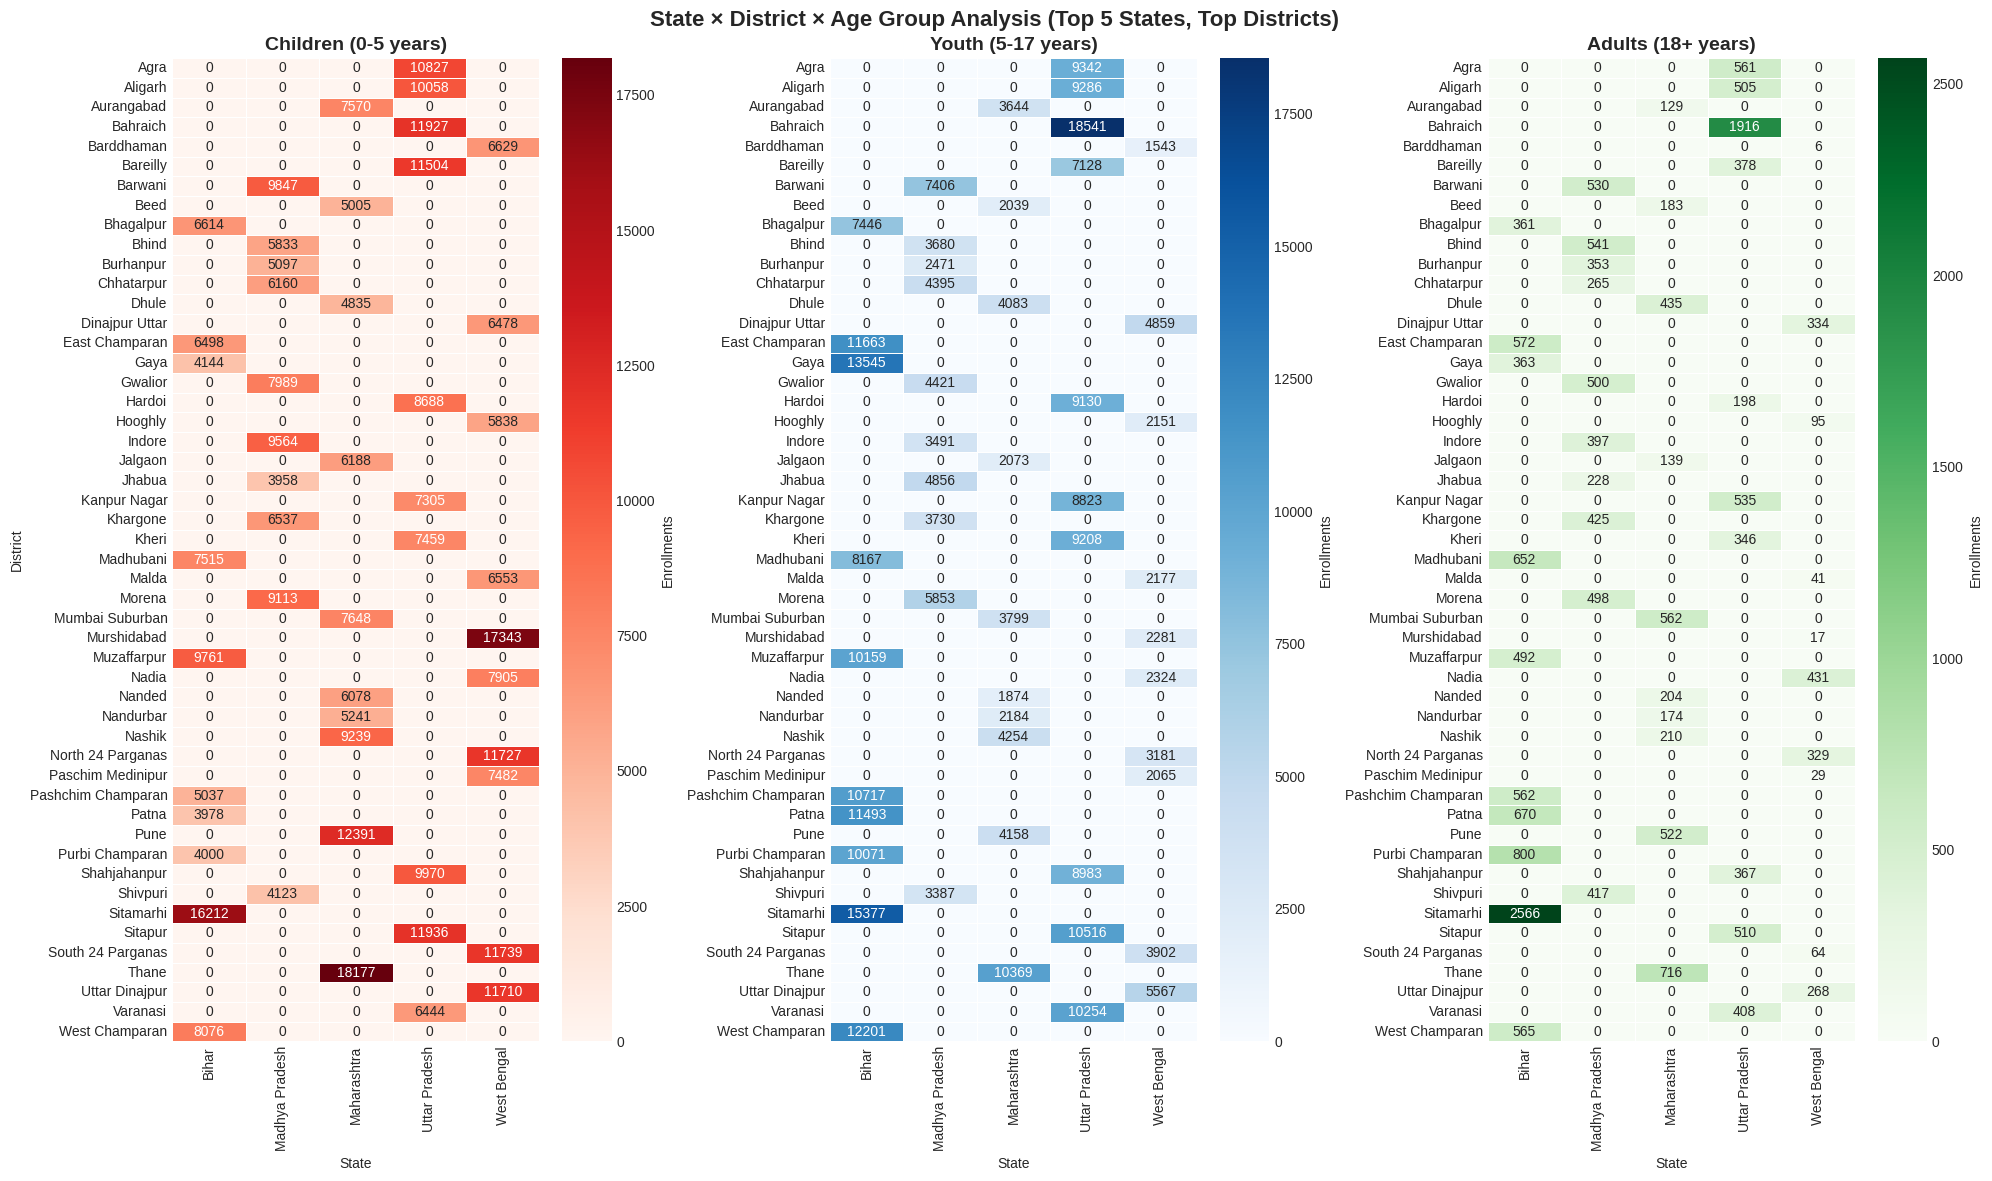

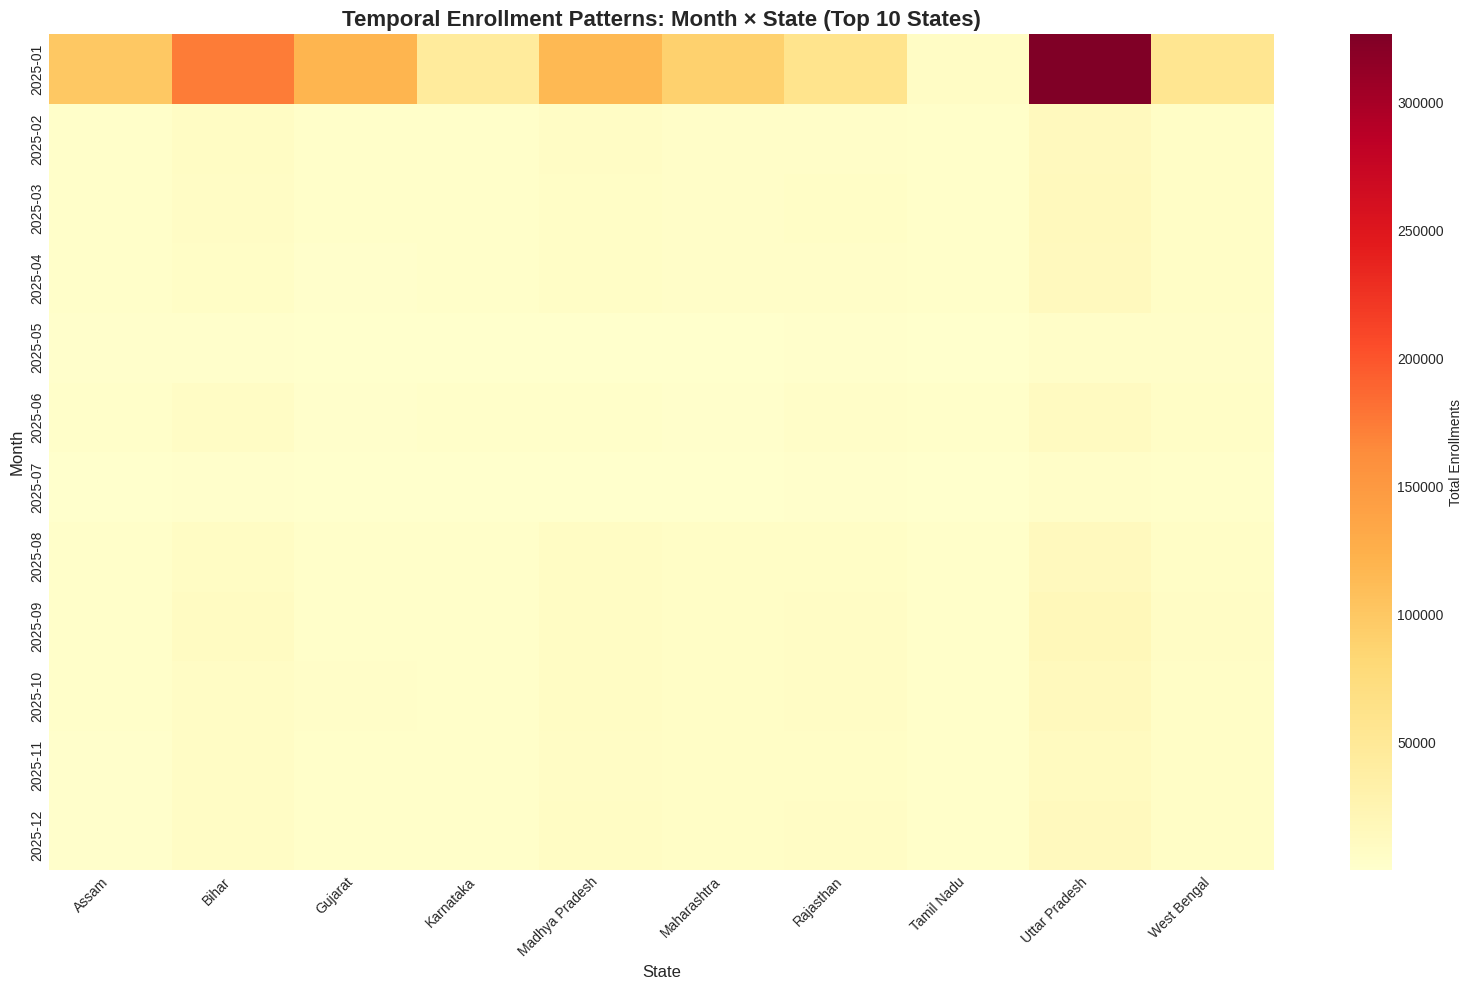


📊 3. Complex Multi-Variable Analysis...


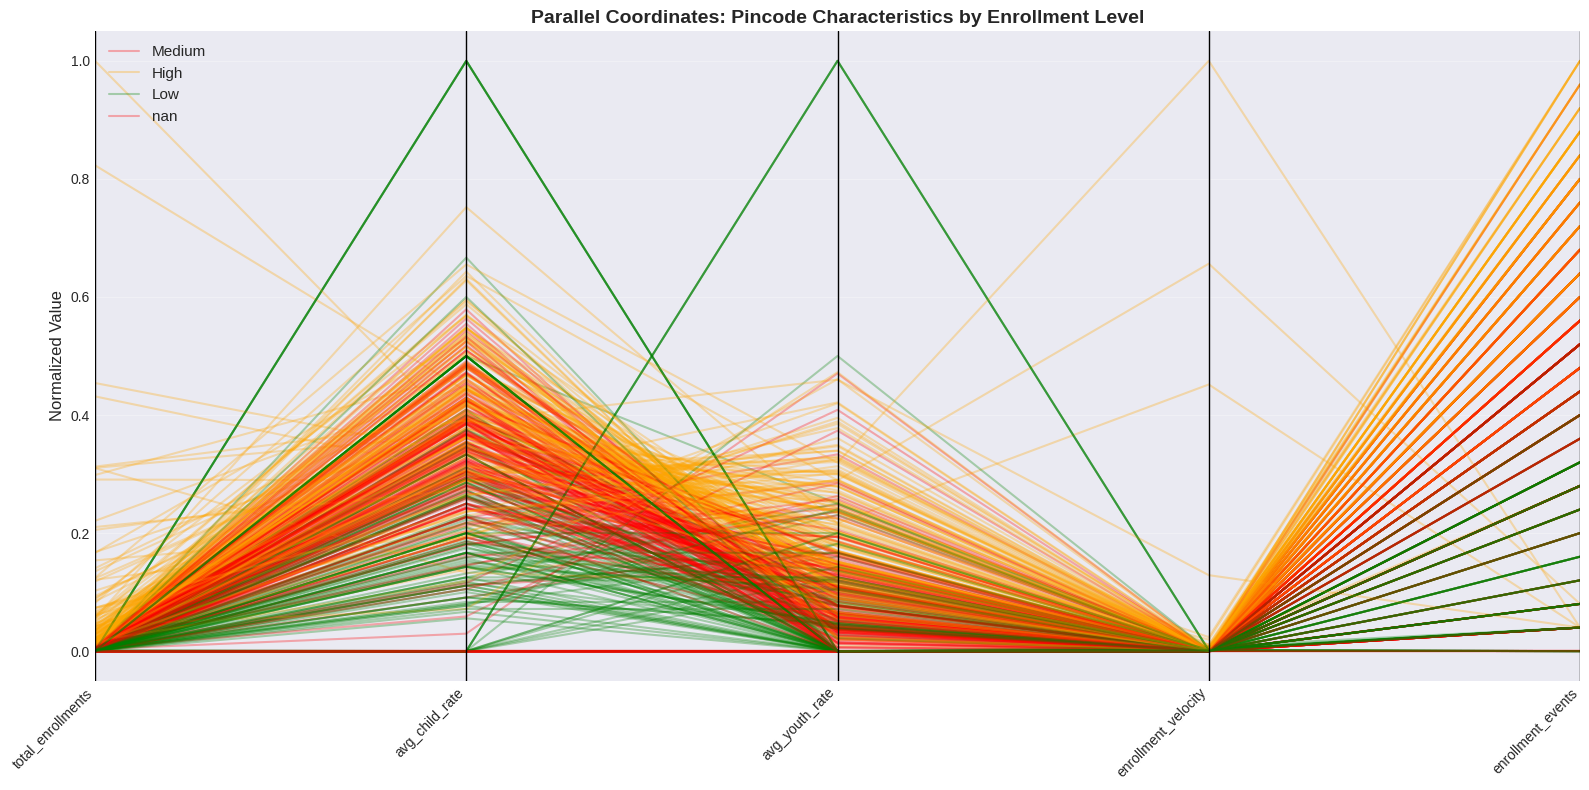


📊 Trivariate Analysis Summary:
   Created 6 advanced visualizations
   Interactive HTML files: 3
   Static complex plots: 3

✅ PHASE 6 COMPLETE: Trivariate Analysis Done!


In [ ]:
## **PHASE 6: Trivariate Analysis & Advanced Visualizations**

# ========================================
# PHASE 6: Trivariate Analysis
# ========================================

print("📊 Starting Trivariate Analysis...")
print("=" * 60)

# ==========================================
# 1. INTERACTIVE PLOTLY VISUALIZATIONS
# ==========================================

print("\n🌐 1. Creating Interactive Visualizations...")

# 1.1 3D Scatter Plot: Child Rate × Total Enrollments × Enrollment Velocity
fig = go.Figure(data=[go.Scatter3d(
    x=pincode_agg['avg_child_rate'],
    y=np.log1p(pincode_agg['total_enrollments']),
    z=pincode_agg['enrollment_velocity'],
    mode='markers',
    marker=dict(
        size=4,
        color=pincode_agg['is_metro'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Metro Status"),
        opacity=0.7
    ),
    text=[f"Pincode: {p}<br>State: {s}<br>District: {d}"
          for p, s, d in zip(pincode_agg['pincode'], pincode_agg['state'], pincode_agg['district'])],
    hovertemplate='<b>%{text}</b><br>Child Rate: %{x:.1f}%<br>Log(Enrollments): %{y:.2f}<br>Velocity: %{z:.2f}<extra></extra>'
)])

fig.update_layout(
    title='3D Analysis: Child Rate × Enrollments × Velocity',
    scene=dict(
        xaxis_title='Child Enrollment Rate (%)',
        yaxis_title='Log(Total Enrollments + 1)',
        zaxis_title='Enrollment Velocity'
    ),
    width=900,
    height=700
)

fig.write_html('figures/16_3d_scatter_plot.html')
print("✅ Created: 16_3d_scatter_plot.html")

# 1.2 Animated bubble chart: State enrollments over time
# Prepare monthly state data
monthly_state_full = df_clean.groupby([
    df_clean['date'].dt.to_period('M'), 'state'
]).agg({
    'total_enrollments': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'pincode': 'nunique'
}).reset_index()

monthly_state_full['date'] = monthly_state_full['date'].dt.to_timestamp()
monthly_state_full['date_str'] = monthly_state_full['date'].dt.strftime('%Y-%m')

# Get top 10 states for clearer visualization
top_10_states_list = state_agg.head(10)['state'].tolist()
monthly_state_top10 = monthly_state_full[monthly_state_full['state'].isin(top_10_states_list)]

fig = px.scatter(monthly_state_top10,
                 x='age_0_5',
                 y='age_18_greater',
                 animation_frame='date_str',
                 animation_group='state',
                 size='total_enrollments',
                 color='state',
                 hover_name='state',
                 size_max=60,
                 range_x=[0, monthly_state_top10['age_0_5'].max()*1.1],
                 range_y=[0, monthly_state_top10['age_18_greater'].max()*1.1],
                 labels={'age_0_5': 'Children Enrollments (0-5)',
                        'age_18_greater': 'Adult Enrollments (18+)',
                        'total_enrollments': 'Total Enrollments'},
                 title='Enrollment Dynamics Over Time: Children vs Adults (Top 10 States)')

fig.update_layout(width=1000, height=700)
fig.write_html('figures/17_animated_bubble_chart.html')
print("✅ Created: 17_animated_bubble_chart.html")

# 1.3 Sunburst chart: Hierarchical view (State → District → Age Distribution)
# Prepare data for sunburst
sunburst_data = []

for _, state_row in state_agg.head(5).iterrows():
    state_name = state_row['state']
    state_total = state_row['total_enrollments']

    # Get districts for this state
    state_districts = district_agg[district_agg['state'] == state_name].head(5)

    for _, dist_row in state_districts.iterrows():
        district_name = dist_row['district']

        # Add age group entries
        sunburst_data.append({
            'labels': state_name,
            'parents': '',
            'values': state_total
        })

        sunburst_data.append({
            'labels': f"{district_name}",
            'parents': state_name,
            'values': dist_row['total_enrollments']
        })

        # Age groups
        sunburst_data.append({
            'labels': f"Children (0-5)",
            'parents': f"{district_name}",
            'values': dist_row['total_age_0_5']
        })

        sunburst_data.append({
            'labels': f"Youth (5-17)",
            'parents': f"{district_name}",
            'values': dist_row['total_age_5_17']
        })

        sunburst_data.append({
            'labels': f"Adults (18+)",
            'parents': f"{district_name}",
            'values': dist_row['total_age_18_greater']
        })

sunburst_df = pd.DataFrame(sunburst_data).drop_duplicates()

fig = go.Figure(go.Sunburst(
    labels=sunburst_df['labels'],
    parents=sunburst_df['parents'],
    values=sunburst_df['values'],
    branchvalues="total",
    marker=dict(colorscale='RdYlGn'),
    hovertemplate='<b>%{label}</b><br>Enrollments: %{value:,.0f}<extra></extra>'
))

fig.update_layout(
    title='Hierarchical Enrollment View: State → District → Age Group (Top 5 States)',
    width=900,
    height=900
)

fig.write_html('figures/18_sunburst_hierarchy.html')
print("✅ Created: 18_sunburst_hierarchy.html")

# ==========================================
# 2. MULTI-DIMENSIONAL HEATMAPS
# ==========================================

print("\n🔥 2. Creating Multi-Dimensional Heatmaps...")

# 2.1 State × District × Age Group heatmap
# Create faceted heatmap for age groups

# Get top 5 states and their top districts
top_states_for_heatmap = state_agg.head(5)['state'].tolist()
district_for_heatmap = district_agg[district_agg['state'].isin(top_states_for_heatmap)]

# Get top 10 districts per state
top_districts_list = []
for state in top_states_for_heatmap:
    state_top = district_for_heatmap[district_for_heatmap['state'] == state].nlargest(10, 'total_enrollments')
    top_districts_list.append(state_top)

districts_subset = pd.concat(top_districts_list)

# Create three separate heatmaps for each age group
fig, axes = plt.subplots(1, 3, figsize=(20, 12))

# Children (0-5)
pivot_child = districts_subset.pivot_table(
    values='total_age_0_5',
    index='district',
    columns='state',
    fill_value=0
)
sns.heatmap(pivot_child, annot=True, fmt='.0f', cmap='Reds', ax=axes[0],
            cbar_kws={'label': 'Enrollments'}, linewidths=0.5)
axes[0].set_title('Children (0-5 years)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('State')
axes[0].set_ylabel('District')

# Youth (5-17)
pivot_youth = districts_subset.pivot_table(
    values='total_age_5_17',
    index='district',
    columns='state',
    fill_value=0
)
sns.heatmap(pivot_youth, annot=True, fmt='.0f', cmap='Blues', ax=axes[1],
            cbar_kws={'label': 'Enrollments'}, linewidths=0.5)
axes[1].set_title('Youth (5-17 years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('State')
axes[1].set_ylabel('')

# Adults (18+)
pivot_adult = districts_subset.pivot_table(
    values='total_age_18_greater',
    index='district',
    columns='state',
    fill_value=0
)
sns.heatmap(pivot_adult, annot=True, fmt='.0f', cmap='Greens', ax=axes[2],
            cbar_kws={'label': 'Enrollments'}, linewidths=0.5)
axes[2].set_title('Adults (18+ years)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('State')
axes[2].set_ylabel('')

plt.suptitle('State × District × Age Group Analysis (Top 5 States, Top Districts)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('figures/19_multidimensional_heatmap_age.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.2 Month × State × Enrollment Type heatmap
monthly_state_pivot = monthly_state_top10.groupby(['date_str', 'state'])['total_enrollments'].sum().reset_index()
time_state_pivot = monthly_state_pivot.pivot(index='date_str', columns='state', values='total_enrollments')

plt.figure(figsize=(16, 10))
sns.heatmap(time_state_pivot, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Total Enrollments'}, linewidths=0)
plt.title('Temporal Enrollment Patterns: Month × State (Top 10 States)', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/20_temporal_state_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. COMPLEX MULTI-VARIABLE ANALYSIS
# ==========================================

print("\n📊 3. Complex Multi-Variable Analysis...")

# 3.1 Parallel coordinates plot for pincode characteristics
from pandas.plotting import parallel_coordinates

# Select representative pincodes (sample for clarity)
pincode_sample = pincode_agg.sample(min(500, len(pincode_agg)), random_state=42).copy()

# Create categories based on enrollment levels
pincode_sample['enrollment_category'] = pd.cut(
    pincode_sample['total_enrollments'],
    bins=[0, pincode_sample['total_enrollments'].quantile(0.33),
          pincode_sample['total_enrollments'].quantile(0.67),
          pincode_sample['total_enrollments'].max()],
    labels=['Low', 'Medium', 'High']
)

# Normalize features for parallel plot
features_for_parallel = ['total_enrollments', 'avg_child_rate', 'avg_youth_rate',
                         'enrollment_velocity', 'enrollment_events']

pincode_parallel = pincode_sample[features_for_parallel + ['enrollment_category']].copy()

# Normalize
for col in features_for_parallel:
    pincode_parallel[col] = (pincode_parallel[col] - pincode_parallel[col].min()) / \
                            (pincode_parallel[col].max() - pincode_parallel[col].min())

plt.figure(figsize=(16, 8))
parallel_coordinates(pincode_parallel, 'enrollment_category',
                    color=['red', 'orange', 'green'], alpha=0.3)
plt.title('Parallel Coordinates: Pincode Characteristics by Enrollment Level', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/21_parallel_coordinates.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Trivariate Analysis Summary:")
print(f"   Created 6 advanced visualizations")
print(f"   Interactive HTML files: 3")
print(f"   Static complex plots: 3")

print("\n" + "=" * 60)
print("✅ PHASE 6 COMPLETE: Trivariate Analysis Done!")
print("=" * 60)


🤖 Starting Machine Learning - Clustering Analysis...

🔧 1. Feature Engineering for Clustering...
✅ Feature matrix created: (28833, 9)
   Features: 9
   Samples: 28833

📊 2. K-Means Clustering Analysis...

🔍 Finding optimal number of clusters...
   K=3: Inertia=179941.78, Silhouette=0.338
   K=4: Inertia=158397.80, Silhouette=0.323
   K=5: Inertia=136388.69, Silhouette=0.323
   K=6: Inertia=121809.57, Silhouette=0.316
   K=7: Inertia=107665.92, Silhouette=0.320
   K=8: Inertia=94468.71, Silhouette=0.325
   K=9: Inertia=86172.70, Silhouette=0.337
   K=10: Inertia=79981.86, Silhouette=0.286


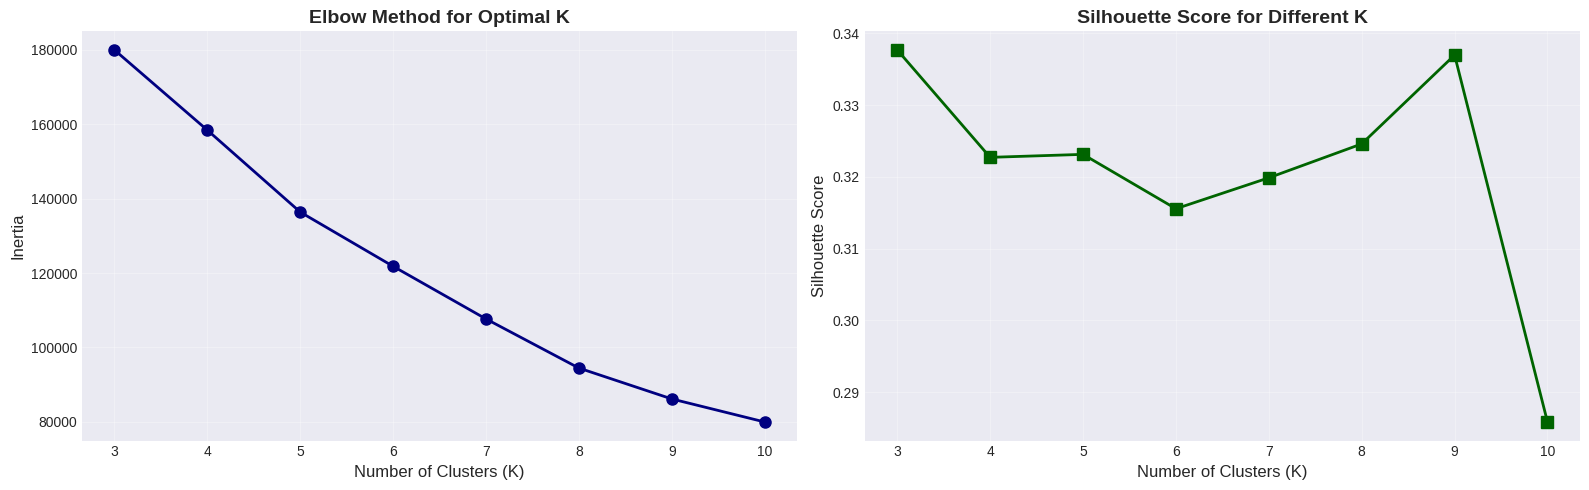


✅ Optimal K selected: 3
✅ K-Means clustering complete with K=3

📊 Cluster Analysis:
               total_enrollments                avg_child_rate  \
                            mean     std  count           mean   
kmeans_cluster                                                   
0                         155.98  424.44  18911          39.15   
1                         173.52  460.40   1476          32.66   
2                           7.95   39.18   8446          16.60   

               enrollment_velocity is_metro  
                              mean     mean  
kmeans_cluster                               
0                             1.04     0.00  
1                            59.91     0.95  
2                             1.07     0.00  

🎯 Cluster Profiles:

   Cluster 0: Moderate Urban Coverage
      Pincodes: 18911
      Avg Enrollments: 156
      Metro %: 0.0%
      Avg Child Rate: 39.1%

   Cluster 1: High Coverage Metro Areas
      Pincodes: 1476
      Avg Enrollments: 

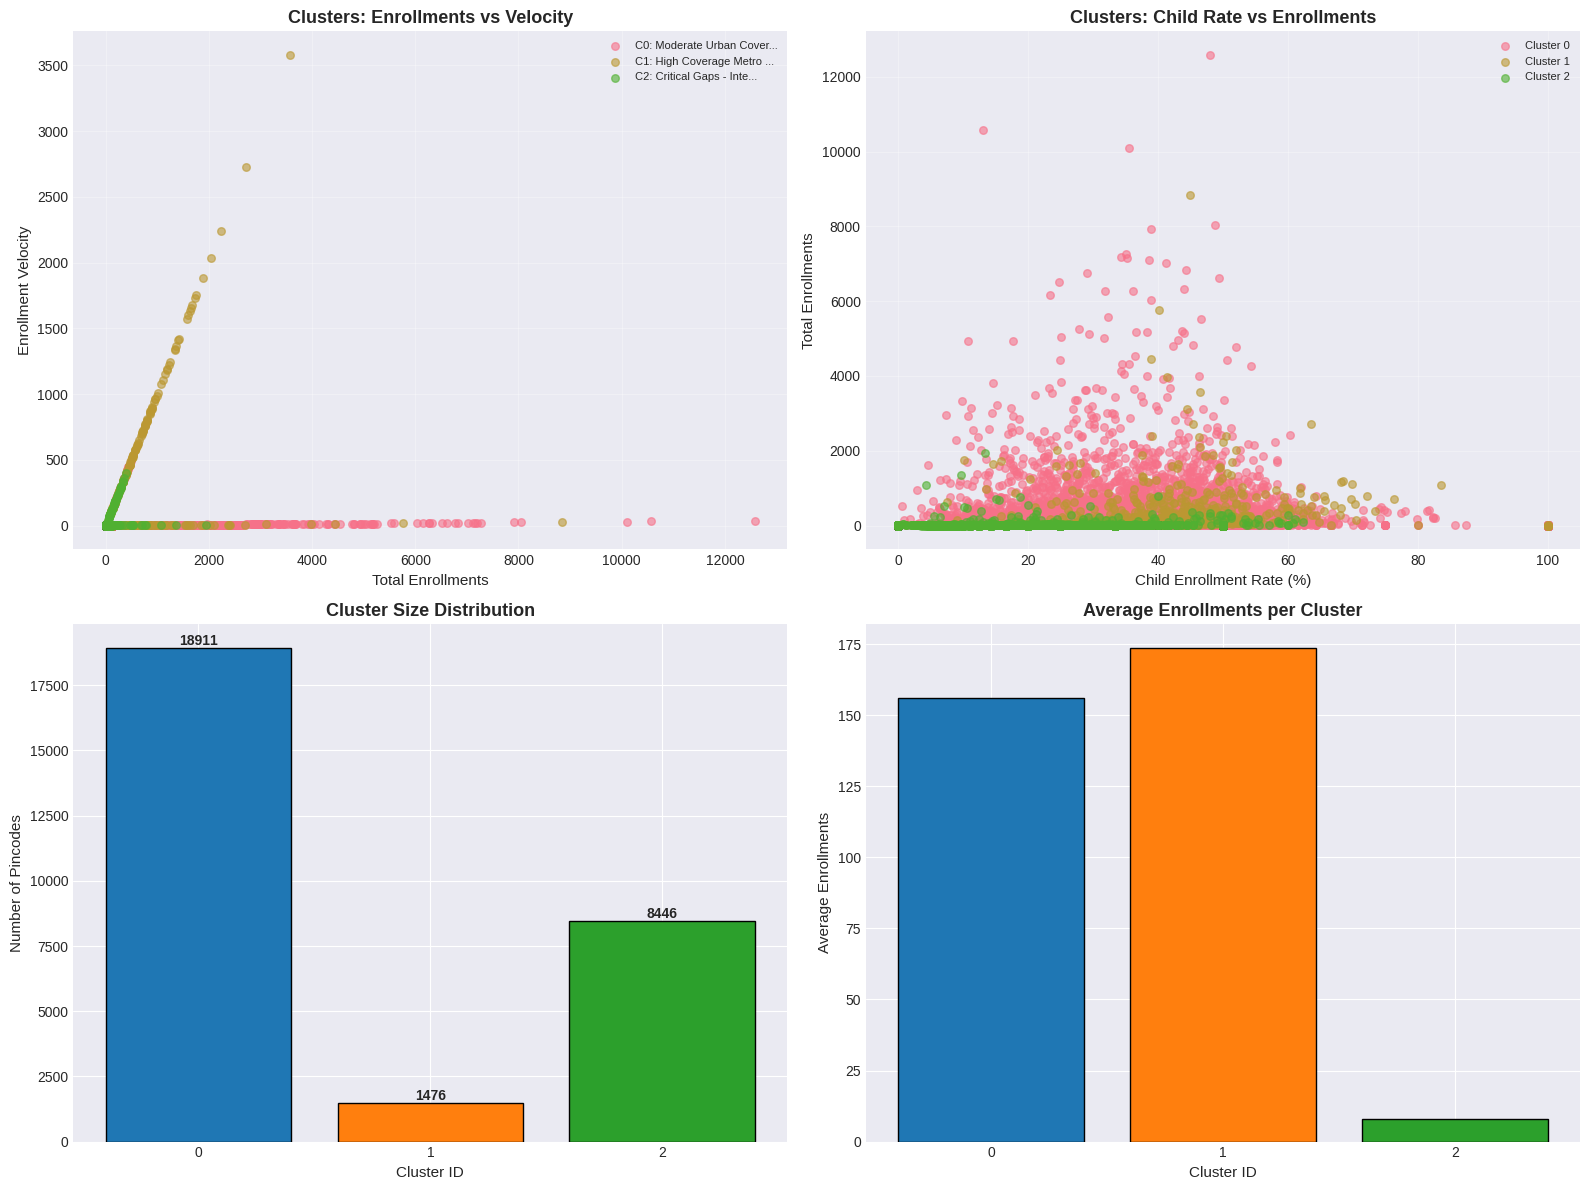


📊 3. DBSCAN Clustering Analysis...


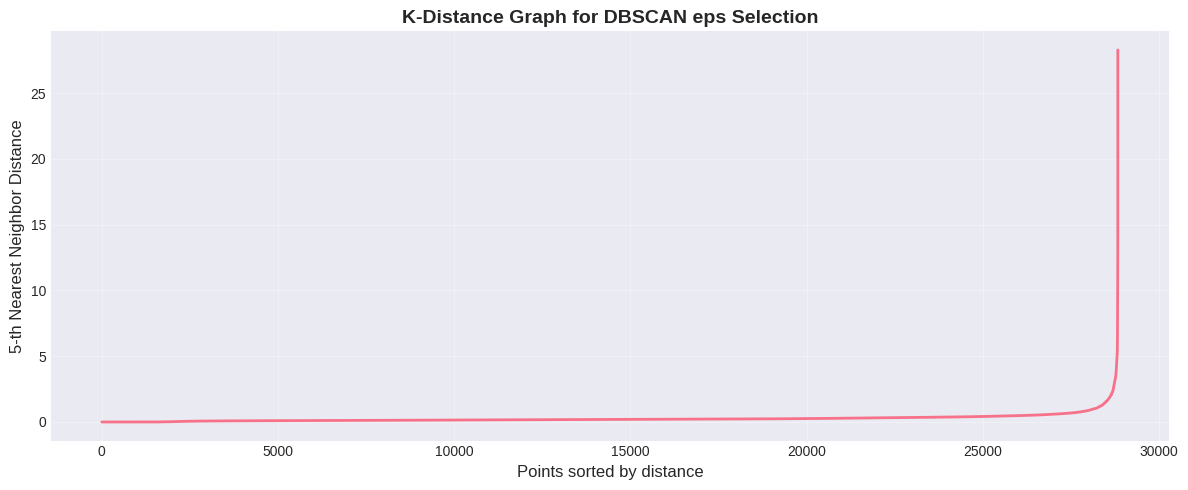


🔍 Selected eps value: 0.481

✅ DBSCAN Results:
   Number of clusters: 23
   Number of noise points (outliers): 2925
   Noise percentage: 10.14%


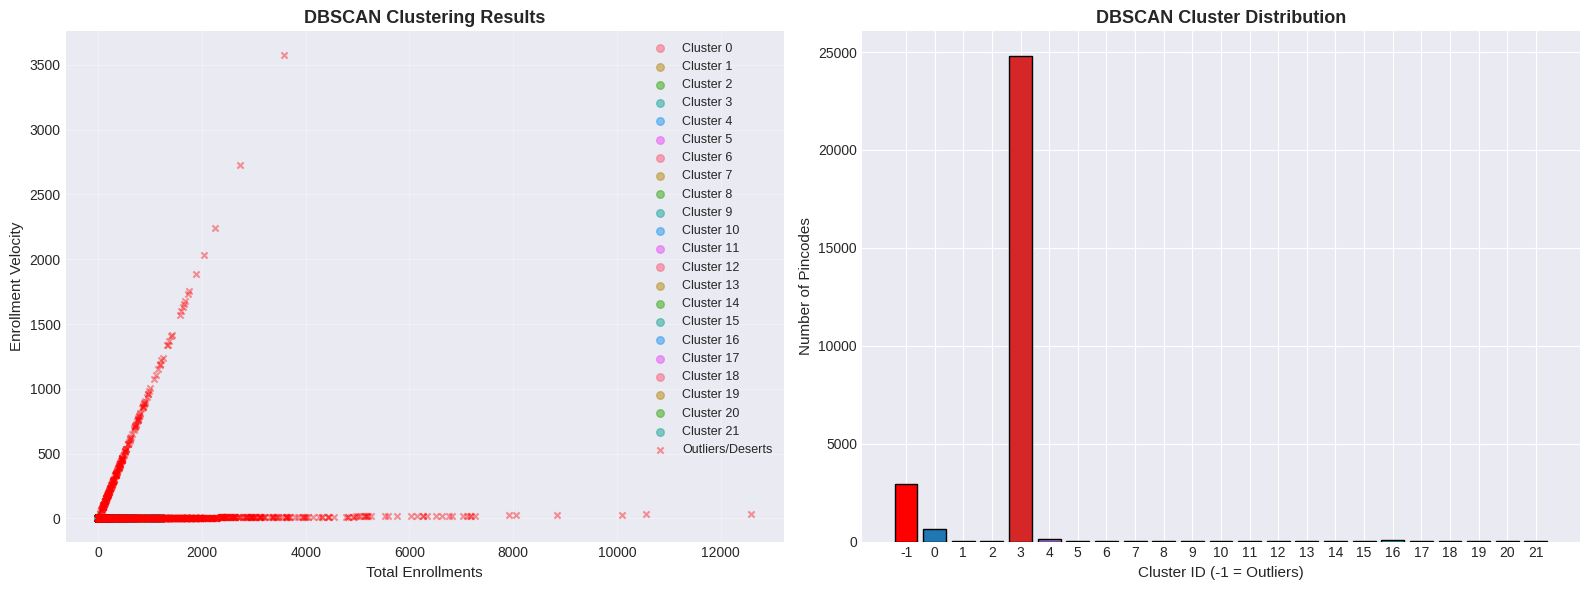


🌳 4. Hierarchical Clustering Dendrogram...


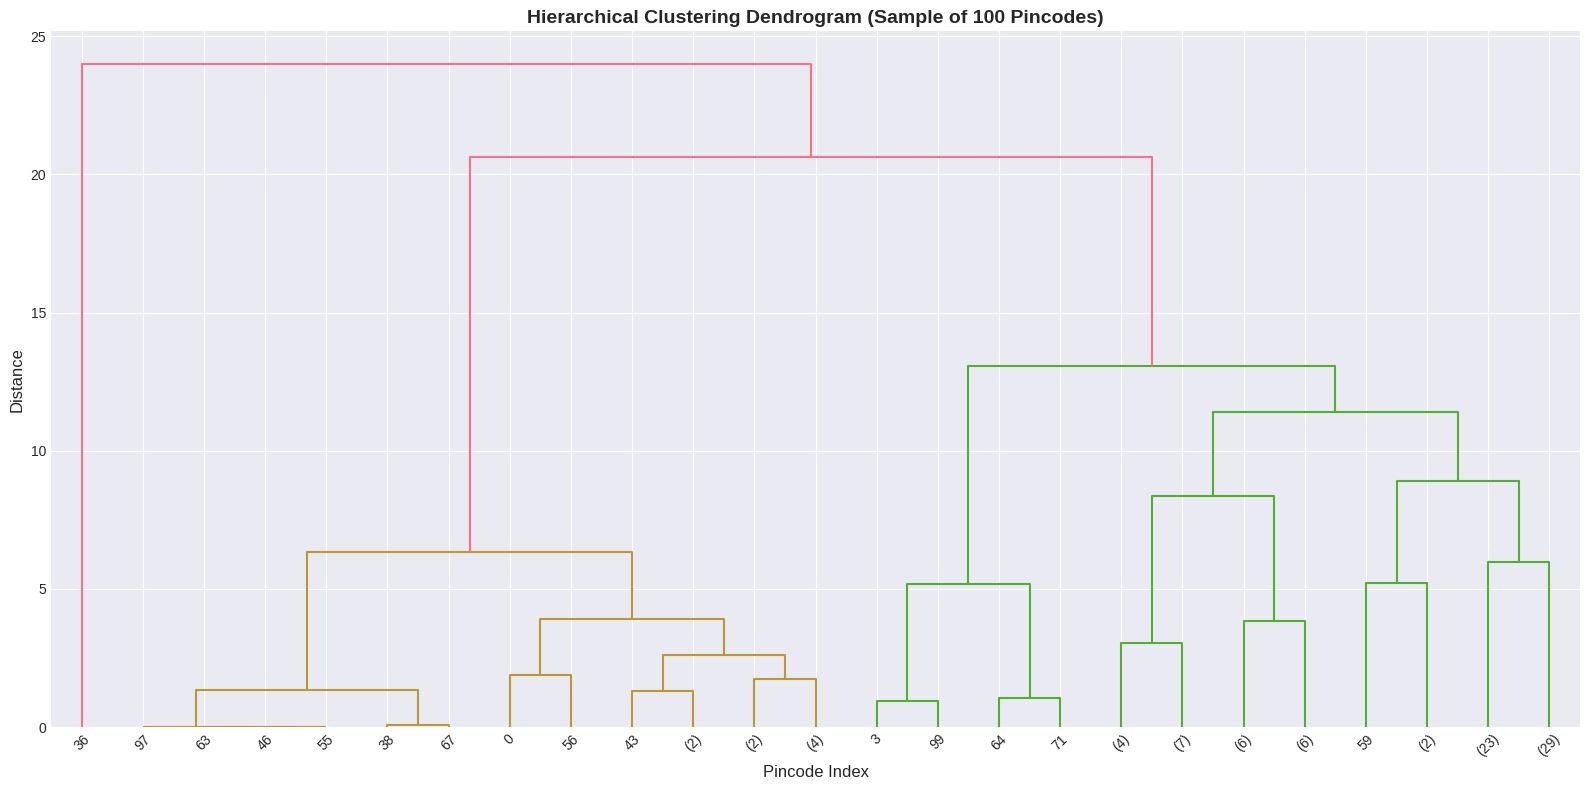


✅ Clustered data saved to: pincode_with_clusters.csv

✅ PHASE 7 COMPLETE: Clustering Analysis Done!
   - K-Means: 3 clusters identified
   - DBSCAN: 23 clusters, 2925 outliers
   - Hierarchical: Dendrogram created


In [ ]:
# ========================================
# PHASE 7: Machine Learning - Clustering
# ========================================

print("🤖 Starting Machine Learning - Clustering Analysis...")
print("=" * 60)

# ==========================================
# 1. FEATURE ENGINEERING FOR ML
# ==========================================

print("\n🔧 1. Feature Engineering for Clustering...")

# Create feature matrix for clustering
ml_data = pincode_agg.copy()

# Calculate additional features
# Enrollment consistency (std deviation of age rates)
ml_data['age_rate_std'] = ml_data[['avg_child_rate', 'avg_youth_rate', 'avg_adult_rate']].std(axis=1)

# Calculate percentiles for comparative features
ml_data['enrollment_percentile'] = ml_data['total_enrollments'].rank(pct=True) * 100
ml_data['velocity_percentile'] = ml_data['enrollment_velocity'].rank(pct=True) * 100
ml_data['child_rate_percentile'] = ml_data['avg_child_rate'].rank(pct=True) * 100

# Create feature set for clustering
feature_columns = [
    'total_enrollments',
    'avg_child_rate',
    'avg_youth_rate',
    'avg_adult_rate',
    'enrollment_velocity',
    'enrollment_events',
    'enrollment_duration_days',
    'is_metro',
    'age_rate_std'
]

# Remove any rows with NaN in feature columns
ml_data_clean = ml_data.dropna(subset=feature_columns).copy()

# Prepare feature matrix
X = ml_data_clean[feature_columns].values

print(f"✅ Feature matrix created: {X.shape}")
print(f"   Features: {len(feature_columns)}")
print(f"   Samples: {len(X)}")

# ==========================================
# 2. K-MEANS CLUSTERING
# ==========================================

print("\n📊 2. K-Means Clustering Analysis...")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal K using Elbow Method and Silhouette Score
inertias = []
silhouette_scores = []
K_range = range(3, 11)

print("\n🔍 Finding optimal number of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"   K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot Elbow and Silhouette
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow plot
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8, color='navy')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='darkgreen')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score for Different K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/22_kmeans_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Select optimal K (based on silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal K selected: {optimal_k}")

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
ml_data_clean['kmeans_cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"✅ K-Means clustering complete with K={optimal_k}")

# Analyze clusters
print("\n📊 Cluster Analysis:")
cluster_summary = ml_data_clean.groupby('kmeans_cluster').agg({
    'total_enrollments': ['mean', 'std', 'count'],
    'avg_child_rate': 'mean',
    'enrollment_velocity': 'mean',
    'is_metro': 'mean'
}).round(2)

print(cluster_summary)

# Profile each cluster
print("\n🎯 Cluster Profiles:")
cluster_names = {}
for cluster_id in range(optimal_k):
    cluster_data = ml_data_clean[ml_data_clean['kmeans_cluster'] == cluster_id]
    avg_enrollment = cluster_data['total_enrollments'].mean()
    metro_pct = cluster_data['is_metro'].mean() * 100

    # Assign meaningful names
    if avg_enrollment > ml_data_clean['total_enrollments'].quantile(0.75) and metro_pct > 50:
        name = "High Coverage Metro Areas"
    elif avg_enrollment < ml_data_clean['total_enrollments'].quantile(0.25):
        name = "Critical Gaps - Intervention Needed"
    elif metro_pct < 20 and avg_enrollment < ml_data_clean['total_enrollments'].median():
        name = "Rural Underserved"
    elif avg_enrollment > ml_data_clean['total_enrollments'].median():
        name = "Moderate Urban Coverage"
    else:
        name = "Emerging Coverage Areas"

    cluster_names[cluster_id] = name
    print(f"\n   Cluster {cluster_id}: {name}")
    print(f"      Pincodes: {len(cluster_data)}")
    print(f"      Avg Enrollments: {avg_enrollment:.0f}")
    print(f"      Metro %: {metro_pct:.1f}%")
    print(f"      Avg Child Rate: {cluster_data['avg_child_rate'].mean():.1f}%")

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot 1: Enrollments vs Velocity
for cluster_id in range(optimal_k):
    cluster_data = ml_data_clean[ml_data_clean['kmeans_cluster'] == cluster_id]
    axes[0, 0].scatter(cluster_data['total_enrollments'],
                       cluster_data['enrollment_velocity'],
                       label=f"C{cluster_id}: {cluster_names[cluster_id][:20]}...",
                       alpha=0.6, s=30)
axes[0, 0].set_xlabel('Total Enrollments', fontsize=11)
axes[0, 0].set_ylabel('Enrollment Velocity', fontsize=11)
axes[0, 0].set_title('Clusters: Enrollments vs Velocity', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot 2: Child Rate vs Total Enrollments
for cluster_id in range(optimal_k):
    cluster_data = ml_data_clean[ml_data_clean['kmeans_cluster'] == cluster_id]
    axes[0, 1].scatter(cluster_data['avg_child_rate'],
                       cluster_data['total_enrollments'],
                       label=f"Cluster {cluster_id}",
                       alpha=0.6, s=30)
axes[0, 1].set_xlabel('Child Enrollment Rate (%)', fontsize=11)
axes[0, 1].set_ylabel('Total Enrollments', fontsize=11)
axes[0, 1].set_title('Clusters: Child Rate vs Enrollments', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Cluster size distribution
cluster_sizes = ml_data_clean['kmeans_cluster'].value_counts().sort_index()
axes[1, 0].bar(range(optimal_k), cluster_sizes, color=plt.cm.tab10(range(optimal_k)), edgecolor='black')
axes[1, 0].set_xlabel('Cluster ID', fontsize=11)
axes[1, 0].set_ylabel('Number of Pincodes', fontsize=11)
axes[1, 0].set_title('Cluster Size Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(range(optimal_k))
for i, v in enumerate(cluster_sizes):
    axes[1, 0].text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Average enrollments per cluster
avg_enrollments_cluster = ml_data_clean.groupby('kmeans_cluster')['total_enrollments'].mean()
axes[1, 1].bar(range(optimal_k), avg_enrollments_cluster, color=plt.cm.tab10(range(optimal_k)), edgecolor='black')
axes[1, 1].set_xlabel('Cluster ID', fontsize=11)
axes[1, 1].set_ylabel('Average Enrollments', fontsize=11)
axes[1, 1].set_title('Average Enrollments per Cluster', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(range(optimal_k))

plt.tight_layout()
plt.savefig('figures/23_kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. DBSCAN CLUSTERING
# ==========================================

print("\n📊 3. DBSCAN Clustering Analysis...")

# DBSCAN for density-based clustering
from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance graph
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 5))
plt.plot(distances, linewidth=2)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph for DBSCAN eps Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/24_dbscan_eps_selection.png', dpi=300, bbox_inches='tight')
plt.show()

# Try different eps values
eps_value = np.percentile(distances, 90)  # Use 90th percentile as eps
print(f"\n🔍 Selected eps value: {eps_value:.3f}")

# Fit DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=10)
ml_data_clean['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
n_clusters_dbscan = len(set(ml_data_clean['dbscan_cluster'])) - (1 if -1 in ml_data_clean['dbscan_cluster'] else 0)
n_noise = list(ml_data_clean['dbscan_cluster']).count(-1)

print(f"\n✅ DBSCAN Results:")
print(f"   Number of clusters: {n_clusters_dbscan}")
print(f"   Number of noise points (outliers): {n_noise}")
print(f"   Noise percentage: {n_noise/len(ml_data_clean)*100:.2f}%")

# Visualize DBSCAN results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DBSCAN clusters
for cluster_id in set(ml_data_clean['dbscan_cluster']):
    cluster_data = ml_data_clean[ml_data_clean['dbscan_cluster'] == cluster_id]
    if cluster_id == -1:
        axes[0].scatter(cluster_data['total_enrollments'],
                       cluster_data['enrollment_velocity'],
                       label='Outliers/Deserts', c='red', alpha=0.4, s=20, marker='x')
    else:
        axes[0].scatter(cluster_data['total_enrollments'],
                       cluster_data['enrollment_velocity'],
                       label=f'Cluster {cluster_id}', alpha=0.6, s=30)

axes[0].set_xlabel('Total Enrollments', fontsize=11)
axes[0].set_ylabel('Enrollment Velocity', fontsize=11)
axes[0].set_title('DBSCAN Clustering Results', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Cluster distribution
dbscan_counts = ml_data_clean['dbscan_cluster'].value_counts().sort_index()
colors = ['red' if x == -1 else plt.cm.tab10(x) for x in dbscan_counts.index]
axes[1].bar(range(len(dbscan_counts)), dbscan_counts.values, color=colors, edgecolor='black')
axes[1].set_xlabel('Cluster ID (-1 = Outliers)', fontsize=11)
axes[1].set_ylabel('Number of Pincodes', fontsize=11)
axes[1].set_title('DBSCAN Cluster Distribution', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(len(dbscan_counts)))
axes[1].set_xticklabels(dbscan_counts.index)

plt.tight_layout()
plt.savefig('figures/25_dbscan_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. HIERARCHICAL CLUSTERING (OPTIONAL)
# ==========================================

print("\n🌳 4. Hierarchical Clustering Dendrogram...")

# Sample data for dendrogram (too many points will be unreadable)
sample_size = min(100, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Perform hierarchical clustering
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram (Sample of 100 Pincodes)', fontsize=14, fontweight='bold')
plt.xlabel('Pincode Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig('figures/26_hierarchical_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Save clustered data
ml_data_clean.to_csv('pincode_with_clusters.csv', index=False)
print("\n✅ Clustered data saved to: pincode_with_clusters.csv")

print("\n" + "=" * 60)
print("✅ PHASE 7 COMPLETE: Clustering Analysis Done!")
print(f"   - K-Means: {optimal_k} clusters identified")
print(f"   - DBSCAN: {n_clusters_dbscan} clusters, {n_noise} outliers")
print(f"   - Hierarchical: Dendrogram created")
print("=" * 60)

🏜️  Starting Enrollment Desert Identification...

📋 1. Defining Desert Criteria...

📊 Desert Thresholds:
   Enrollment 10th percentile: 2.00
   Child rate 20th percentile: 19.05%
   Velocity 10th percentile: 0.0099
   Critical Gap Cluster ID: 2

✅ Desert Identification Complete:
   Total pincodes analyzed: 28833
   Pincodes meeting criteria:
      Low enrollment: 2757
      Low child rate: 5738
      Critical cluster: 8446
      DBSCAN outliers: 2925
   Total deserts identified: 11341

🎯 2. Creating Desert Identification Index (DII)...

📊 Desert Severity Distribution:
desert_severity
Adequate            13070
Moderate Concern     7259
High Risk            5656
Critical Desert      2848
Name: count, dtype: int64

🚨 Critical Attention Needed:
   Critical deserts: 2848
   High risk areas: 5656
   Total urgent interventions: 8504


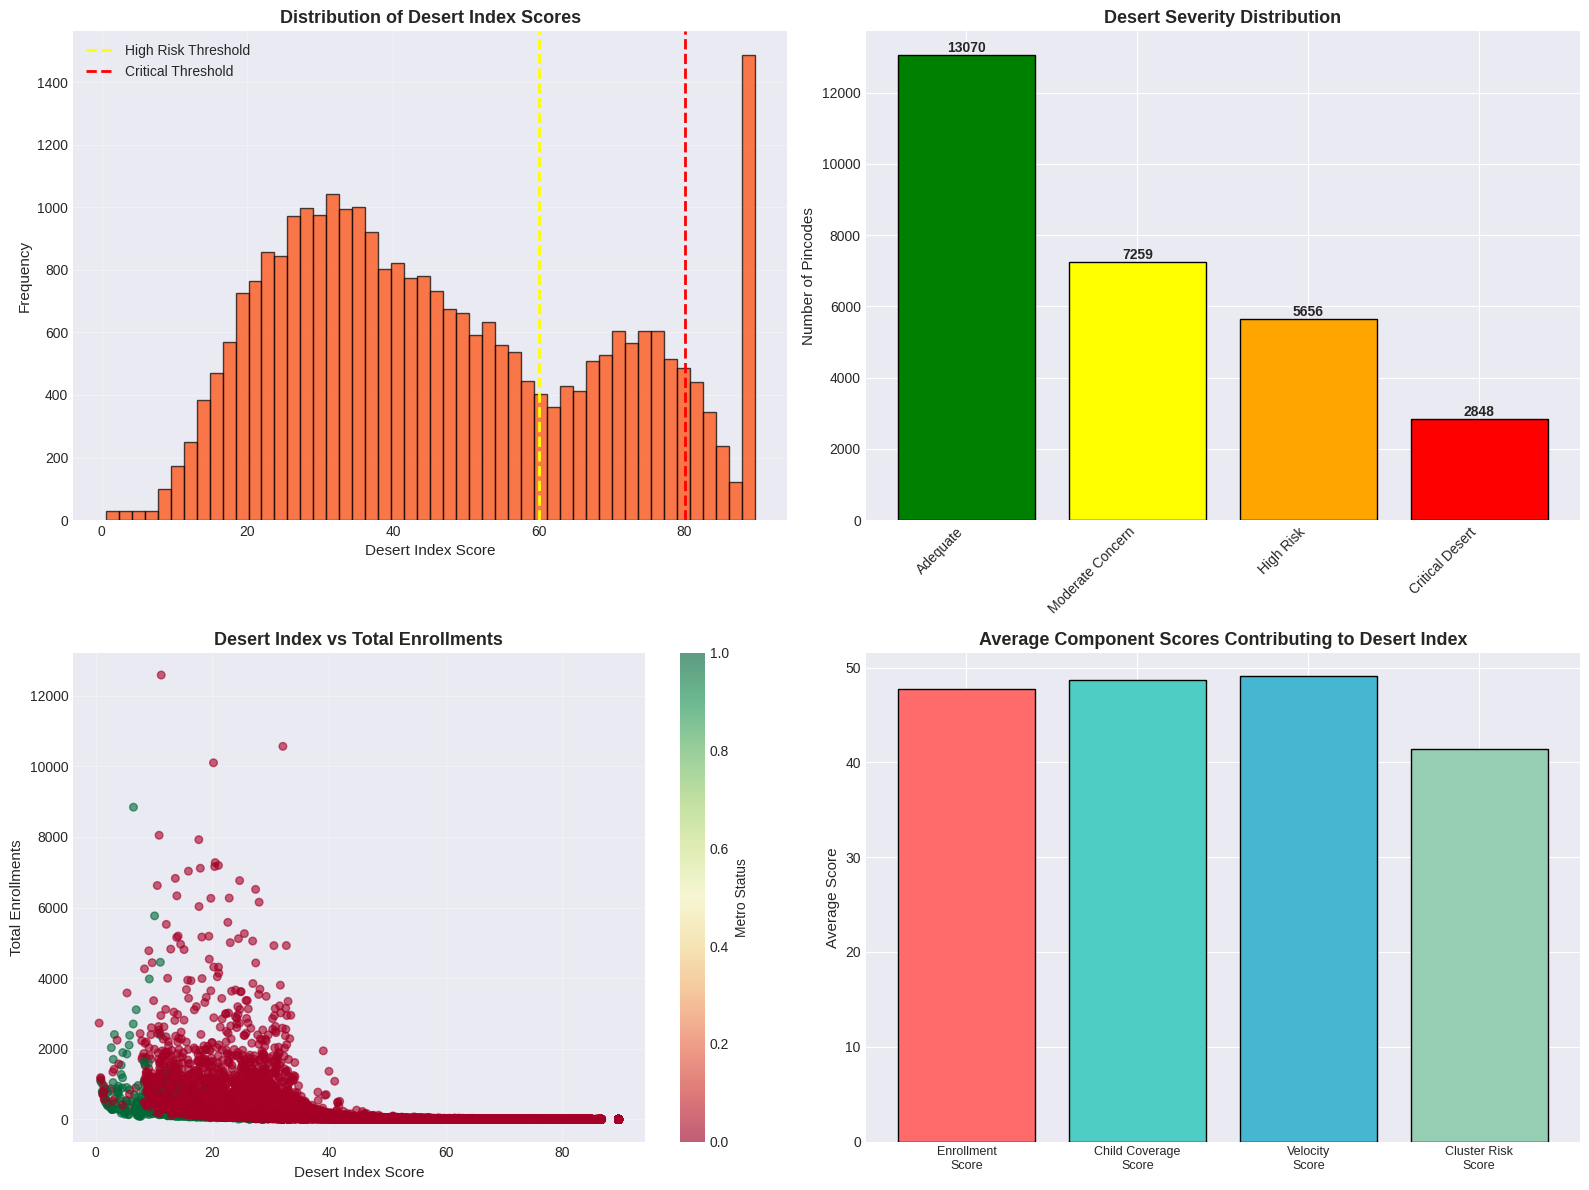


🗺️  3. Creating Geographic Desert Maps...

🚨 Top 20 Critical Deserts:
pincode      state           district  desert_index  total_enrollments  avg_child_rate
 121014    Haryana          Faridabad     89.666052                0.0             0.0
 122007    Haryana            Gurgaon     89.666052                0.0             0.0
 123401    Haryana            Gurgaon     89.666052                0.0             0.0
 127041    Haryana              Hisar     89.666052                0.0             0.0
 133004    Haryana          Panchkula     89.666052                0.0             0.0
 134105    Haryana          Panchkula     89.666052                0.0             0.0
 135002    Haryana        Yamunanagar     89.666052                0.0             0.0
 140306     Punjab           Rupnagar     89.666052                0.0             0.0
 140417     Punjab SAS Nagar (Mohali)     89.666052                0.0             0.0
 140602     Punjab           Rupnagar     89.666052        

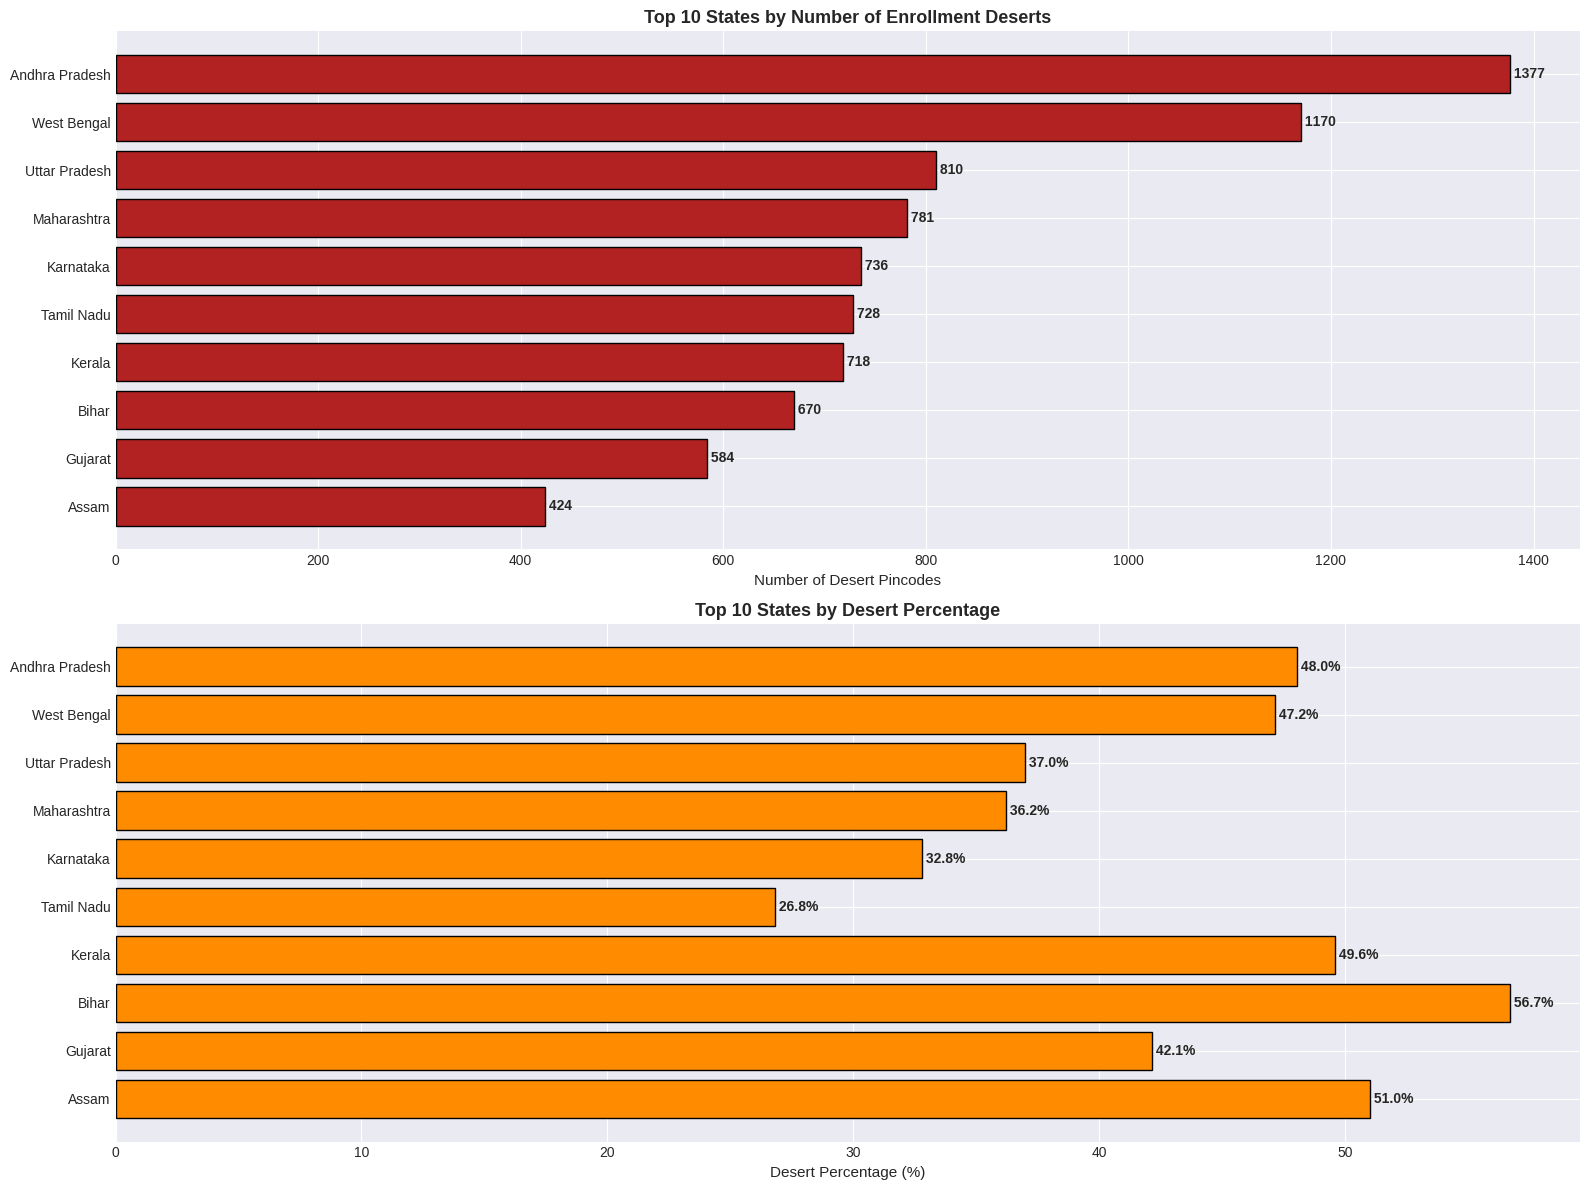


🌐 Creating Interactive Desert Map...
✅ Created: 29_desert_sunburst_map.html

✅ Desert data saved:
   - enrollment_deserts.csv (all pincodes with desert scores)
   - critical_deserts.csv (critical deserts only)

✅ PHASE 8 COMPLETE: Enrollment Deserts Identified!
   - Total deserts: 11341
   - Critical deserts: 2848
   - High risk: 5656


In [ ]:
# ========================================
# PHASE 8: Enrollment Desert Identification
# ========================================

print("🏜️  Starting Enrollment Desert Identification...")
print("=" * 60)

# ==========================================
# 1. DEFINE DESERT CRITERIA
# ==========================================

print("\n📋 1. Defining Desert Criteria...")

# Load clustered data
desert_data = ml_data_clean.copy()

# Calculate percentiles for thresholds
enrollment_10th = desert_data['total_enrollments'].quantile(0.10)
child_rate_20th = desert_data['avg_child_rate'].quantile(0.20)
velocity_10th = desert_data['enrollment_velocity'].quantile(0.10)

print(f"\n📊 Desert Thresholds:")
print(f"   Enrollment 10th percentile: {enrollment_10th:.2f}")
print(f"   Child rate 20th percentile: {child_rate_20th:.2f}%")
print(f"   Velocity 10th percentile: {velocity_10th:.4f}")

# Identify critical gap cluster from K-Means
critical_cluster_id = desert_data.groupby('kmeans_cluster')['total_enrollments'].mean().idxmin()
print(f"   Critical Gap Cluster ID: {critical_cluster_id}")

# Apply desert criteria
desert_data['is_low_enrollment'] = (desert_data['total_enrollments'] < enrollment_10th).astype(int)
desert_data['is_low_child_rate'] = (desert_data['avg_child_rate'] < child_rate_20th).astype(int)
desert_data['is_critical_cluster'] = (desert_data['kmeans_cluster'] == critical_cluster_id).astype(int)
desert_data['is_dbscan_outlier'] = (desert_data['dbscan_cluster'] == -1).astype(int)

# A pincode is a desert if it meets ANY of the criteria
desert_data['is_desert'] = (
    (desert_data['is_low_enrollment'] == 1) |
    (desert_data['is_low_child_rate'] == 1) |
    (desert_data['is_critical_cluster'] == 1) |
    (desert_data['is_dbscan_outlier'] == 1)
).astype(int)

print(f"\n✅ Desert Identification Complete:")
print(f"   Total pincodes analyzed: {len(desert_data)}")
print(f"   Pincodes meeting criteria:")
print(f"      Low enrollment: {desert_data['is_low_enrollment'].sum()}")
print(f"      Low child rate: {desert_data['is_low_child_rate'].sum()}")
print(f"      Critical cluster: {desert_data['is_critical_cluster'].sum()}")
print(f"      DBSCAN outliers: {desert_data['is_dbscan_outlier'].sum()}")
print(f"   Total deserts identified: {desert_data['is_desert'].sum()}")

# ==========================================
# 2. CREATE DESERT IDENTIFICATION INDEX
# ==========================================

print("\n🎯 2. Creating Desert Identification Index (DII)...")

# Calculate component scores (0-100 scale, inverted so higher = worse)
desert_data['enrollment_score'] = 100 - (desert_data['enrollment_percentile'])
desert_data['child_coverage_score'] = 100 - (desert_data['child_rate_percentile'])
desert_data['velocity_score'] = 100 - (desert_data['velocity_percentile'])

# Cluster risk score based on cluster average
cluster_avg_enrollment = desert_data.groupby('kmeans_cluster')['total_enrollments'].mean()
cluster_risk = 100 - ((cluster_avg_enrollment.rank(pct=True) * 100))
desert_data['cluster_risk_score'] = desert_data['kmeans_cluster'].map(cluster_risk)

# Calculate weighted Desert Index (0-100)
desert_data['desert_index'] = (
    desert_data['enrollment_score'] * 0.3 +
    desert_data['child_coverage_score'] * 0.3 +
    desert_data['velocity_score'] * 0.2 +
    desert_data['cluster_risk_score'] * 0.2
)

# Categorize desert severity
desert_data['desert_severity'] = pd.cut(
    desert_data['desert_index'],
    bins=[0, 40, 60, 80, 100],
    labels=['Adequate', 'Moderate Concern', 'High Risk', 'Critical Desert']
)

print(f"\n📊 Desert Severity Distribution:")
print(desert_data['desert_severity'].value_counts().sort_index())

# Identify critical deserts
critical_deserts = desert_data[desert_data['desert_severity'] == 'Critical Desert']
high_risk_deserts = desert_data[desert_data['desert_severity'] == 'High Risk']

print(f"\n🚨 Critical Attention Needed:")
print(f"   Critical deserts: {len(critical_deserts)}")
print(f"   High risk areas: {len(high_risk_deserts)}")
print(f"   Total urgent interventions: {len(critical_deserts) + len(high_risk_deserts)}")

# Visualize Desert Index distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram of Desert Index
axes[0, 0].hist(desert_data['desert_index'], bins=50, color='orangered', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(60, color='yellow', linestyle='--', linewidth=2, label='High Risk Threshold')
axes[0, 0].axvline(80, color='red', linestyle='--', linewidth=2, label='Critical Threshold')
axes[0, 0].set_xlabel('Desert Index Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Desert Index Scores', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Severity categories
severity_counts = desert_data['desert_severity'].value_counts()
colors_severity = ['green', 'yellow', 'orange', 'red']
axes[0, 1].bar(range(len(severity_counts)), severity_counts.values,
               color=colors_severity, edgecolor='black')
axes[0, 1].set_xticks(range(len(severity_counts)))
axes[0, 1].set_xticklabels(severity_counts.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Pincodes', fontsize=11)
axes[0, 1].set_title('Desert Severity Distribution', fontsize=13, fontweight='bold')
for i, v in enumerate(severity_counts.values):
    axes[0, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Scatter: Desert Index vs Total Enrollments
scatter = axes[1, 0].scatter(desert_data['desert_index'],
                             desert_data['total_enrollments'],
                             c=desert_data['is_metro'], cmap='RdYlGn',
                             alpha=0.6, s=30)
axes[1, 0].set_xlabel('Desert Index Score', fontsize=11)
axes[1, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[1, 0].set_title('Desert Index vs Total Enrollments', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Metro Status')

# Component contribution to Desert Index
component_means = desert_data[[
    'enrollment_score', 'child_coverage_score',
    'velocity_score', 'cluster_risk_score'
]].mean()

axes[1, 1].bar(range(len(component_means)), component_means.values,
               color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'], edgecolor='black')
axes[1, 1].set_xticks(range(len(component_means)))
axes[1, 1].set_xticklabels(['Enrollment\nScore', 'Child Coverage\nScore',
                            'Velocity\nScore', 'Cluster Risk\nScore'], fontsize=9)
axes[1, 1].set_ylabel('Average Score', fontsize=11)
axes[1, 1].set_title('Average Component Scores Contributing to Desert Index', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/27_desert_index_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. GEOGRAPHIC MAPPING OF DESERTS
# ==========================================

print("\n🗺️  3. Creating Geographic Desert Maps...")

# Top 20 critical deserts
top_critical_deserts = critical_deserts.nlargest(20, 'desert_index')

print("\n🚨 Top 20 Critical Deserts:")
print(top_critical_deserts[['pincode', 'state', 'district', 'desert_index',
                            'total_enrollments', 'avg_child_rate']].to_string(index=False))

# State-wise desert analysis
state_desert_summary = desert_data.groupby('state').agg({
    'desert_index': 'mean',
    'is_desert': 'sum',
    'pincode': 'count'
}).reset_index()

state_desert_summary.columns = ['state', 'avg_desert_index', 'num_deserts', 'total_pincodes']
state_desert_summary['desert_percentage'] = (
    state_desert_summary['num_deserts'] / state_desert_summary['total_pincodes'] * 100
).round(2)
state_desert_summary = state_desert_summary.sort_values('num_deserts', ascending=False)

print("\n📊 Top 10 States by Number of Deserts:")
print(state_desert_summary.head(10).to_string(index=False))

# Visualize state-wise deserts
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Top states by number of deserts
top_10_desert_states = state_desert_summary.head(10)
axes[0].barh(range(10), top_10_desert_states['num_deserts'], color='firebrick', edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_10_desert_states['state'])
axes[0].set_xlabel('Number of Desert Pincodes', fontsize=11)
axes[0].set_title('Top 10 States by Number of Enrollment Deserts', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(top_10_desert_states['num_deserts']):
    axes[0].text(v, i, f' {v}', va='center', fontsize=10, fontweight='bold')

# Desert percentage by state
axes[1].barh(range(10), top_10_desert_states['desert_percentage'], color='darkorange', edgecolor='black')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(top_10_desert_states['state'])
axes[1].set_xlabel('Desert Percentage (%)', fontsize=11)
axes[1].set_title('Top 10 States by Desert Percentage', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(top_10_desert_states['desert_percentage']):
    axes[1].text(v, i, f' {v:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/28_state_desert_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Interactive Plotly map
print("\n🌐 Creating Interactive Desert Map...")

fig = px.scatter_geo(
    desert_data,
    lat=None,  # We don't have lat/long, so this is conceptual
    lon=None,
    color='desert_severity',
    size='desert_index',
    hover_data=['pincode', 'state', 'district', 'total_enrollments', 'desert_index'],
    title='Geographic Distribution of Enrollment Deserts (Conceptual)',
    color_discrete_map={
        'Adequate': 'green',
        'Moderate Concern': 'yellow',
        'High Risk': 'orange',
        'Critical Desert': 'red'
    }
)

# Note: Since we don't have actual lat/long coordinates, we'll create an alternative visualization
# Create a sunburst of deserts by state and district

desert_subset = desert_data[desert_data['desert_severity'].isin(['High Risk', 'Critical Desert'])].copy()
desert_subset['severity_state'] = desert_subset['state'] + ' - ' + desert_subset['desert_severity'].astype(str)

# Create sunburst chart
fig = px.sunburst(
    desert_subset.head(200),  # Limit for performance
    path=['state', 'district', 'desert_severity'],
    values='desert_index',
    title='Hierarchical View of Enrollment Deserts: State → District → Severity',
    color='desert_index',
    color_continuous_scale='Reds'
)

fig.update_layout(width=900, height=900)
fig.write_html('figures/29_desert_sunburst_map.html')
print("✅ Created: 29_desert_sunburst_map.html")

# Save desert data
desert_data.to_csv('enrollment_deserts.csv', index=False)
critical_deserts.to_csv('critical_deserts.csv', index=False)

print(f"\n✅ Desert data saved:")
print(f"   - enrollment_deserts.csv (all pincodes with desert scores)")
print(f"   - critical_deserts.csv (critical deserts only)")

print("\n" + "=" * 60)
print("✅ PHASE 8 COMPLETE: Enrollment Deserts Identified!")
print(f"   - Total deserts: {desert_data['is_desert'].sum()}")
print(f"   - Critical deserts: {len(critical_deserts)}")
print(f"   - High risk: {len(high_risk_deserts)}")
print("=" * 60)

In [ ]:
# ================================================================
# GEOGRAPHIC ACCESSIBILITY OPTIMIZER - PHASES 9 & 10 (SIMPLIFIED)
# Optimization & Predictive Modeling
# ================================================================

print("="*80)
print("PHASES 9 & 10: OPTIMIZATION & PREDICTIVE MODELING (SIMPLIFIED)")
print("="*80)

# ================================================================
# SETUP
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import os
os.makedirs('figures', exist_ok=True)

print("✅ Libraries loaded\n")

# ================================================================
# LOAD DATA
# ================================================================

print("Loading data...")
desert_data = pd.read_csv('enrollment_deserts.csv')
print(f"✅ Loaded {len(desert_data):,} pincodes\n")

# ================================================================
# PHASE 9: OPTIMIZATION
# ================================================================

print("="*80)
print("PHASE 9: OPTIMIZATION")
print("="*80)

# Step 1: Identify existing centers (top 10%)
print("\n1. Identifying existing centers...")
threshold = desert_data['total_enrollments'].quantile(0.90)
existing_centers = desert_data[desert_data['total_enrollments'] >= threshold]
print(f"   ✅ {len(existing_centers):,} existing centers identified\n")

# Step 2: Get critical areas
print("2. Identifying critical areas...")
critical_areas = desert_data[
    desert_data['desert_severity'].isin(['Critical Desert', 'High Risk'])
].copy()
print(f"   ✅ {len(critical_areas):,} critical areas found\n")

# Step 3: Cluster critical areas for new centers
print("3. Clustering for optimal center placement...")
n_centers = 25

features = ['total_enrollments', 'desert_index', 'avg_child_rate', 'enrollment_velocity']
X = critical_areas[features].fillna(0).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=n_centers, random_state=42)
critical_areas['cluster'] = kmeans.fit_predict(X_scaled)

# Get one center per cluster
centers = []
for i in range(n_centers):
    cluster_data = critical_areas[critical_areas['cluster'] == i]
    if len(cluster_data) > 0:
        best = cluster_data.nlargest(1, 'desert_index').iloc[0]
        centers.append({
            'pincode': best['pincode'],
            'state': best['state'],
            'district': best['district'],
            'pincodes_covered': len(cluster_data),
            'priority_score': best['desert_index'] * len(cluster_data)
        })

centers_df = pd.DataFrame(centers).sort_values('priority_score', ascending=False)
print(f"   ✅ {len(centers_df)} new centers recommended\n")

print("Top 10 Priority Centers:")
print(centers_df.head(10)[['pincode', 'state', 'district', 'pincodes_covered']].to_string(index=False))

# Step 4: Mobile routes
print("\n4. Creating mobile camp routes...")
n_routes = 5
routes = []

for idx, row in centers_df.head(n_routes).iterrows():
    cluster_data = critical_areas[critical_areas['cluster'] == row['cluster']]
    routes.append({
        'route_id': idx + 1,
        'base': row['pincode'],
        'state': row['state'],
        'stops': min(8, len(cluster_data)),
        'beneficiaries': cluster_data['total_enrollments'].sum()
    })

routes_df = pd.DataFrame(routes)
print(f"   ✅ {len(routes_df)} mobile routes created\n")

# Step 5: Impact calculation
print("5. Calculating impact...")
current_deserts = len(critical_areas)
pincodes_covered = centers_df['pincodes_covered'].sum()
projected_deserts = max(0, current_deserts - pincodes_covered)

current_rate = (current_deserts / len(desert_data)) * 100
projected_rate = (projected_deserts / len(desert_data)) * 100
improvement = ((current_rate - projected_rate) / current_rate) * 100

print(f"\n📊 IMPACT SUMMARY:")
print(f"   Current deserts: {current_deserts:,} ({current_rate:.2f}%)")
print(f"   Projected deserts: {projected_deserts:,} ({projected_rate:.2f}%)")
print(f"   Improvement: {improvement:.1f}%")
print(f"   Pincodes covered: {pincodes_covered:,}\n")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Priority scores
axes[0, 0].bar(range(len(centers_df)), centers_df['priority_score'], color='green')
axes[0, 0].set_title('Priority Scores for New Centers', fontweight='bold')
axes[0, 0].set_xlabel('Center Rank')
axes[0, 0].set_ylabel('Priority Score')

# 2. Coverage
axes[0, 1].bar(range(len(centers_df)), centers_df['pincodes_covered'], color='blue')
axes[0, 1].set_title('Pincodes Covered per Center', fontweight='bold')
axes[0, 1].set_xlabel('Center Rank')
axes[0, 1].set_ylabel('Pincodes Covered')

# 3. Before/After
cats = ['Current', 'Projected']
vals = [current_rate, projected_rate]
axes[1, 0].bar(cats, vals, color=['red', 'green'])
axes[1, 0].set_title('Desert Rate: Before vs After', fontweight='bold')
axes[1, 0].set_ylabel('Desert Rate (%)')
for i, v in enumerate(vals):
    axes[1, 0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Mobile routes
axes[1, 1].bar(routes_df['route_id'], routes_df['beneficiaries'], color='purple')
axes[1, 1].set_title('Mobile Camp Beneficiaries', fontweight='bold')
axes[1, 1].set_xlabel('Route ID')
axes[1, 1].set_ylabel('Beneficiaries')

plt.tight_layout()
plt.savefig('figures/phase9_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
centers_df.to_csv('recommended_centers.csv', index=False)
routes_df.to_csv('mobile_routes.csv', index=False)
print("✅ Files saved: recommended_centers.csv, mobile_routes.csv\n")

print("="*80)
print("✅ PHASE 9 COMPLETE")
print("="*80)

# ================================================================
# PHASE 10: PREDICTIVE MODELING
# ================================================================

print("\n" + "="*80)
print("PHASE 10: PREDICTIVE MODELING")
print("="*80)

# Prepare data
print("\n1. Preparing classification data...")
classification_data = desert_data.copy()

features = [
    'total_enrollments', 'avg_child_rate', 'avg_youth_rate',
    'enrollment_velocity', 'enrollment_events', 'is_metro',
    'enrollment_percentile', 'age_rate_std'
]

# Clean data
data_clean = classification_data[features + ['is_desert']].dropna()
X = data_clean[features].values
y = data_clean['is_desert'].values

print(f"   ✅ {len(X):,} samples prepared")
print(f"   Desert: {y.sum():,} ({y.sum()/len(y)*100:.1f}%)")
print(f"   Non-desert: {len(y)-y.sum():,}\n")

# Train-test split
print("2. Training classification model...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance
class_weight = {0: 1, 1: (len(y) - y.sum()) / y.sum()}

# Train model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight=class_weight,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"   ✅ Model trained")
print(f"   Accuracy: {accuracy:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Desert', 'Desert']))

# Early Warning System
print("\n3. Early Warning System...")
all_probs = model.predict_proba(X)[:, 1]
data_clean['risk_probability'] = all_probs

# Identify at-risk (high probability but not currently desert)
at_risk = data_clean[
    (data_clean['risk_probability'] > 0.6) &
    (data_clean['is_desert'] == 0)
].copy()

at_risk = at_risk.sort_values('risk_probability', ascending=False)

print(f"   ✅ {len(at_risk):,} at-risk pincodes identified")

if len(at_risk) > 0:
    print(f"\nTop 10 At-Risk Pincodes:")
    # Merge to get pincode info
    at_risk_full = classification_data.loc[at_risk.index, ['pincode', 'state', 'district', 'total_enrollments']]
    at_risk_full['risk_prob'] = at_risk['risk_probability'].values
    print(at_risk_full.head(10).to_string(index=False))

# Feature importance
print("\n4. Feature importance...")
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df.to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non-Desert', 'Desert'],
            yticklabels=['Non-Desert', 'Desert'])
axes[0, 0].set_title('Confusion Matrix', fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')

# 2. Feature importance
axes[0, 1].barh(range(len(importance_df)), importance_df['importance'], color='darkblue')
axes[0, 1].set_yticks(range(len(importance_df)))
axes[0, 1].set_yticklabels(importance_df['feature'], fontsize=9)
axes[0, 1].set_title('Feature Importance', fontweight='bold')
axes[0, 1].invert_yaxis()

# 3. Risk distribution
axes[1, 0].hist(data_clean['risk_probability'], bins=50, color='orange', edgecolor='black')
axes[1, 0].axvline(0.6, color='red', linestyle='--', linewidth=2, label='At-Risk Threshold')
axes[1, 0].set_title('Risk Probability Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Risk Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# 4. Risk categories
risk_cats = pd.cut(data_clean['risk_probability'],
                   bins=[0, 0.3, 0.6, 0.8, 1.0],
                   labels=['Low', 'Medium', 'High', 'Critical'])
cat_counts = risk_cats.value_counts().sort_index()

axes[1, 1].bar(range(len(cat_counts)), cat_counts.values,
               color=['green', 'yellow', 'orange', 'red'])
axes[1, 1].set_xticks(range(len(cat_counts)))
axes[1, 1].set_xticklabels(cat_counts.index)
axes[1, 1].set_title('Risk Category Distribution', fontweight='bold')
axes[1, 1].set_ylabel('Number of Pincodes')
for i, v in enumerate(cat_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/phase10_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
if len(at_risk) > 0:
    at_risk_full.to_csv('at_risk_pincodes.csv', index=False)
    print("\n✅ File saved: at_risk_pincodes.csv")

importance_df.to_csv('feature_importance.csv', index=False)
print("✅ File saved: feature_importance.csv\n")

print("="*80)
print("✅ PHASE 10 COMPLETE")
print("="*80)

# ================================================================
# FINAL SUMMARY
# ================================================================

print("\n" + "="*80)
print("🎉 FINAL SUMMARY")
print("="*80)

print(f"\n📊 OPTIMIZATION (PHASE 9):")
print(f"   • New centers: {len(centers_df)}")
print(f"   • Mobile routes: {len(routes_df)}")
print(f"   • Coverage improvement: {improvement:.1f}%")
print(f"   • Pincodes covered: {pincodes_covered:,}")

print(f"\n📊 PREDICTION (PHASE 10):")
print(f"   • Model accuracy: {accuracy:.3f}")
print(f"   • At-risk pincodes: {len(at_risk):,}")
print(f"   • Top feature: {importance_df.iloc[0]['feature']}")

print(f"\n📁 OUTPUT FILES:")
print(f"   1. recommended_centers.csv")
print(f"   2. mobile_routes.csv")
print(f"   3. at_risk_pincodes.csv")
print(f"   4. feature_importance.csv")

print(f"\n📊 VISUALIZATIONS:")
print(f"   • figures/phase9_optimization.png")
print(f"   • figures/phase10_prediction.png")

print("\n" + "="*80)
print("✅ ALL COMPLETE!")
print("="*80)

IndentationError: expected an indented block after 'if' statement on line 602 (ipython-input-1724778460.py, line 603)